# hs-code-nlp-classifier-cl

## Proyecto

### Contexto

- El Servicio Nacional de Aduanas de Chile aporta cerca del 30% de los impuestos que financian el desarrollo del país.
- La correcta clasificación (código arancelario) es clave para: a) Cálculo de Aranceles, b) Aplicación de Tratados de Comercio, y  c) Cumplimiento Normativo.
- Estándar Global con Aplicación Local: se utiliza el Sistema Armonizado (HS), un estándar mundial (95% de adherencia) que requiere de ajustes y jurisprudencia local específicos de Chile.

### Problema

- El Desafío de Clasificar: un proceso manual, específico y dinámico.
- Proceso manual e intenso (tedioso) realizado por operadores humanos (conocimiento experto, sistemas informáticos para registro) de Agencias de Aduana.

### Relevancia

- El error genera riesgo de multas/pérdida de tiempo en correcciones para las Agencias de Aduanas y Operadores de Comercio Exterior, y pérdida de recaudación para Aduanas Chile, afectando la calidad del servicio de las agencias.
- Incumplimiento normativo (las multas afectan a la agencia de aduanas), también puede existir un tiempo de clasificación alto, afectando al cliente y al equipo humano de trabajo.

## Configuraciones

In [153]:
import sys
import json
import inspect
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import torch
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import transformers
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed,
)
import gc
import os
import seaborn as sns
from datetime import datetime

import joblib
import time

import re
import unicodedata

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder




```
path_proyecto = Path.cwd()
path_src = path_proyecto / "src"
if str(path_src) not in sys.path:
    sys.path.append(str(path_src))57

%load_ext autoreload
%autoreload 2
from src.utils import *
from src.csv import *

crear_carpetas()
DIR_RAW_DATA = obtener_path("raw")
DIR_IMAGES = obtener_path("images")
DIR_OUTPUTS = obtener_path("outputs")
DIR_MODELS = obtener_path("models")
DIR_LOG = obtener_path("logs")

SEED = obtener_seed()
print(f"[INFO] Seed usada: {SEED}")

raw_df = cargar_csv(Path(DIR_RAW_DATA, CVV_FILENAME))
```



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
drive_path = Path('/content/drive/MyDrive/')
DIR_RAW_DATA = drive_path / 'hs-code-nlp-classifier-cl/data/raw/'
DIR_IMAGES = drive_path / 'hs-code-nlp-classifier-cl/outputs/images/'
DIR_MODELS = drive_path / 'hs-code-nlp-classifier-cl/models/'
DIR_LOG = drive_path / 'hs-code-nlp-classifier-cl/outputs/log/'
DATASET_FILENAME = "mercancias20260111_004347.csv"

In [4]:
# Constantes
SEED = 42
COL_TEXT = "mercancia_descripcion"
COL_CODE = "partida_arancelaria_codigo"
COL_LEN = "len_descripcion"

TEST_MODE = False

In [5]:
# Guarda la configuración actual de formato de flotantes
original_float_format = pd.get_option('display.float_format')

# Establece el formato de flotantes a 2 decimales para una salida más limpia
pd.set_option('display.float_format', '{:.2f}'.format)


# Restaura la configuración original de formato de flotantes
#pd.set_option('display.float_format', original_float_format)

## Dataset

In [6]:
full_dataset_path = drive_path / DIR_RAW_DATA / DATASET_FILENAME

# Carga el dataset usando pandas
try:
    raw_df = pd.read_csv(full_dataset_path)
    print(f"[INFO] Dataset '{DATASET_FILENAME}' cargado exitosamente. Las primeras 5 filas son:")
    print(raw_df.head())
except FileNotFoundError:
    print(f"[ERROR] Archivo no encontrado en: {full_dataset_path}")
    print("Por favor, verifica la ruta y el nombre del archivo en tu Google Drive.")
except Exception as e:
    print(f"[ERROR] Ocurrió un error al cargar el dataset: {e}")

[INFO] Dataset 'mercancias20260111_004347.csv' cargado exitosamente. Las primeras 5 filas son:
   mercancia_id  ingreso_id  ingreso_detalle_id  ingreso_detalle_posicion  \
0        179381       11056               46336                         0   
1        231855       14491               40994                         0   
2        236368       14506               41813                         0   
3        236368       14506               41807                         0   
4        236368       14506               41810                         0   

                               mercancia_descripcion  \
0  CRISOLESM.P.CARBON-F; D/CARBURO D/SILICIO; REF...   
1  DIISOCIONATO DIFENILMETANO POLNO EXISTETAMBOR2...   
2    ACUMULADOR DE PLOMOPT.MUTINDO-F5661812NO EXISTE   
3    ACUMULADOR DE PLOMOPT.MUTINDO-F5661812NO EXISTE   
4    ACUMULADOR DE PLOMOPT.MUTINDO-F5661812NO EXISTE   

                   partida_arancelaria_nombre  partida_arancelaria_codigo  
0                      -- Ret

### Carga Datos Etiquetados

In [7]:
print("[INFO] Dispositivo:")
print(f" - torch.backends.mps.is_available(): {torch.backends.mps.is_available()}")
print(f" - torch.backends.mps.is_built(): {torch.backends.mps.is_built()}")
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print(f" - torch version: {torch.__version__}")
print(f" - device seleccionado: {device}")


[INFO] Dispositivo:
 - torch.backends.mps.is_available(): False
 - torch.backends.mps.is_built(): False
 - torch version: 2.9.0+cu126
 - device seleccionado: cuda


### Exploración

#### Características

**Columnas:**

In [8]:
print(f"[INFO] Columnas del Dataset: {raw_df.columns}")


[INFO] Columnas del Dataset: Index(['mercancia_id', 'ingreso_id', 'ingreso_detalle_id',
       'ingreso_detalle_posicion', 'mercancia_descripcion',
       'partida_arancelaria_nombre', 'partida_arancelaria_codigo'],
      dtype='object')


**Muestra de registros**:

In [9]:
raw_df.sample(10, random_state=SEED)


,mercancia_id,ingreso_id,ingreso_detalle_id,ingreso_detalle_posicion,mercancia_descripcion,partida_arancelaria_nombre,partida_arancelaria_codigo
1024209,692264,462760,3088630,1,SANDVIK-F; DE ACERO; CON LA PARTE OPERANTE DE ...,--- Barrenas,82071330
1634659,1349419,679128,5003825,33,"SANDVIK-F; METAL COMUN; DE TRANSMISION, PARA C...",-- Los demás,84831090
1784752,1572328,720827,5481258,1,HORTUS-F; SNOWBALL; PARA SIEMBRA,---- Coliflor (Brassica oleracea var. botrytis),12099132
2371187,1466123,875224,7335919,28,CANON; GPR-30; PARA IMPRESORA MULTIFUNCIONAL.,--- Los demás,84439990
3217085,3951983,1103186,9346677,21,LRP-F; ECH ANTH ; PREPARACIONES PARA EL CUIDAD...,--- Preparaciones bronceadoras o antisolares,33049970
3943586,794656,1275766,10836098,6,SANDVIK-F; ELECTRICO; APARATO DE CORTE Y PROTE...,"--- Conectores, bornes y terminales",85369013
2528707,1929388,915443,7764475,3,T.M.C.-F; NI SPORT SPF30; PREPARACION PARA EL ...,- Preparaciones para el maquillaje de los labios,33041000
2042541,985283,787097,6344919,2,WACKER-F; SANISIL CLEAR; DE SILICONA,"- Masilla, cementos de resina y demás mástique...",32141000
4226128,1882119,1329507,11477492,3,ORTHO-F; COMPLETO; PARA APARATO DE USO MEDICO,-- Los demás,90279090
1632197,1425718,678470,4997247,1,KRONES-F; DE INTENSIDAD; ELECTRICO,- Convertidores estáticos,85044000


**WordCloud**:

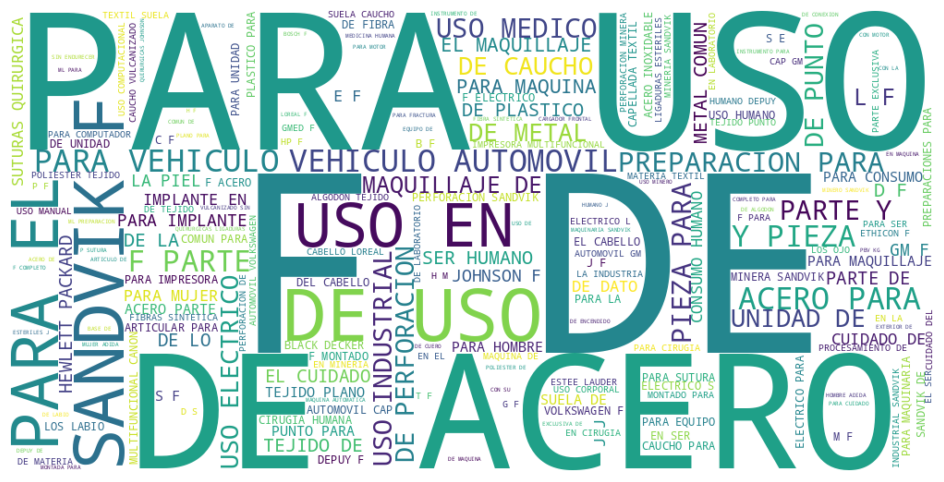

In [10]:
wc_cache_image = "wordcloud-raw-data.png"
wc_cache_path = DIR_IMAGES / wc_cache_image

if wc_cache_path.exists():
    img = Image.open(wc_cache_path)
else:
    # Ensure the directory exists before saving
    os.makedirs(DIR_IMAGES, exist_ok=True)
    text = " ".join(
        raw_df[COL_TEXT]
        .fillna("")
        .astype(str)
        .tolist()
    )
    wc = WordCloud(width=1000, height=500, background_color="white").generate(text)
    img = wc.to_image()
    img.save(wc_cache_path)

plt.figure(figsize=(12,6))
plt.imshow(np.array(img), interpolation="bilinear")
plt.axis("off")
plt.show()

**Notas**:
- La nube muestra que las descripciones están dominadas por términos de uso y destino (“PARA”, “USO”, “PARTE”, “DE”), además de categorías de producto frecuentes como “VEHICULO”, “ACERO”, “SANDVIK”, “TEJIDO”, “PIEZA”. Esto sugiere un lenguaje muy estandarizado y orientado a “para X”, lo que puede introducir stopwords específicas del dominio (ej. “para”, “de”, “uso”) que quizá conviene filtrar en modelos VCM para resaltar términos más discriminantes.

#### Datos no válidos

In [11]:
desc_vacias = (
    raw_df[COL_TEXT]
    .fillna("")
    .str.strip()
    .eq("")
    .sum()
)
print("[INFO] Registros con descripción vacía:", desc_vacias)


[INFO] Registros con descripción vacía: 11872


In [12]:
# Eliminar registros con descripción vacía o solo espacios
data_df = raw_df[
    raw_df[COL_TEXT]
    .fillna("")
    .str.strip()
    .ne("")
].copy()

print("[INFO] Info dataset:")
print(" - Registros totales:", len(raw_df))
print(" - Registros tras limpieza:", len(data_df))


[INFO] Info dataset:
 - Registros totales: 5136897
 - Registros tras limpieza: 5125025


In [13]:
data_df[COL_LEN] = (
    data_df[COL_TEXT]
    .fillna("")
    .astype(str)
    .str.len()
)


In [14]:
data_df[COL_LEN].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])


,len_descripcion
count,5125025.00
mean,53.19
std,19.80
min,1.00
50%,50.00
75%,63.00
90%,80.00
95%,90.00
99%,116.00
max,180.00


**Notas**:
- Se analizaron **5,125,025** descripciones.
- La longitud promedio es **~53 caracteres** y la mediana es **50**, lo que indica textos relativamente cortos.
- El **75%** de las descripciones tiene **≤63 caracteres**.
- El **90%** está bajo **80 caracteres**, y el **95%** bajo **90**.
- El **99%** no supera **116 caracteres**; el máximo observado es **180**.

**Conclusión:** la mayoría de las descripciones son muy breves. Para BERT, un `max_length` de **128** sería suficiente para cubrir casi todo el universo sin truncar.


#### Frecuencias de Clases

In [15]:
total_filas = data_df[COL_CODE].notna().sum()


In [16]:
# Frecuencia de todas las clases

raw_freq_df = data_df[COL_CODE].value_counts()
raw_freq_df.head(20)


,count
partida_arancelaria_codigo,
30061059,126200
90213990,124172
90189089,109399
33041000,107284
84439990,96314
33042000,81872
84314320,75728
33049990,74860
33059090,70094


In [17]:
# Distribución de clases (frecuencia)

raw_freq_df.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])


,count
count,5597.00
mean,915.67
std,5081.94
min,1.00
25%,9.00
50%,51.00
75%,292.00
90%,1381.40
95%,3210.80
99%,17474.40


**notas**
- Se identifican **5.597 clases** distintas.
- La mediana es 51: la mitad de las clases tiene 51 registros o menos.
- El **25% de las clases** tiene **9 registros o menos**, lo que indica presencia de muchas clases poco representadas.
- El 75% tiene ≤292 registros.
- Solo el 10% supera ~1.381 registros.
- El 1% supera ~17.474 registros.
- El máximo es 126.200, alto contraste.
- Conclusiones:
  - Hay muchas clases con muy pocos ejemplos y pocas clases dominantes.
  - Es posible que se deba limitar clases más representadas o agrupar clases poco frecuentes en `OTHER`.
- Para modelar, se puede explorar algunas técnicas:
  - Limitar a las clases más frecuentes
  - Definir etiqueta OTHER para agrupar las poco representadas
  - Aplicar técnicas de balanceo.

In [18]:
# Análisis de cobertura por top N clases

total = raw_freq_df.sum()

for n in [5, 10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    topn = raw_freq_df.head(n)
    rest = raw_freq_df.iloc[n:]
    prop_top = topn.sum() / total * 100
    prop_rest = rest.sum() / total * 100
    print(f"Top {n:4d}: {topn.sum():>10} ({prop_top:6.2f}%) | Resto: {rest.sum():>10} ({prop_rest:6.2f}%)")


Top    5:     563369 ( 10.99%) | Resto:    4561656 ( 89.01%)
Top   10:     923411 ( 18.02%) | Resto:    4201614 ( 81.98%)
Top   20:    1375832 ( 26.85%) | Resto:    3749193 ( 73.15%)
Top   50:    2180000 ( 42.54%) | Resto:    2945025 ( 57.46%)
Top  100:    2825389 ( 55.13%) | Resto:    2299636 ( 44.87%)
Top  200:    3444072 ( 67.20%) | Resto:    1680953 ( 32.80%)
Top  300:    3807509 ( 74.29%) | Resto:    1317516 ( 25.71%)
Top  400:    4057133 ( 79.16%) | Resto:    1067892 ( 20.84%)
Top  500:    4247897 ( 82.89%) | Resto:     877128 ( 17.11%)
Top  600:    4392381 ( 85.70%) | Resto:     732644 ( 14.30%)
Top  700:    4507277 ( 87.95%) | Resto:     617748 ( 12.05%)
Top  800:    4599258 ( 89.74%) | Resto:     525767 ( 10.26%)
Top  900:    4675421 ( 91.23%) | Resto:     449604 (  8.77%)
Top 1000:    4737683 ( 92.44%) | Resto:     387342 (  7.56%)


**Notas**:
- La distribución está fuertemente concentrada: **Top 5** ya cubre **10%** del total.
- Con **Top 10** se cubre **18%**, menos de una quinta parte del universo.
- Al llegar a **Top 50**, se cubre **42%**; es decir, más de la mitad sigue en “resto”.
- El **Top 100** cubre **55%** y el **Top 200** alcanza **67%**.
- Para superar el **80%** de cobertura se necesitan alrededor de **400 clases** (79%) a **500 clases** (82%).
- Para cobertura alta, el número de clases objetivo debe ser grande (≈400–500 para >80%).
- Para un modelo más acotado, conviene usar `OTHER` para el resto o limitarse a un Top‑N más pequeño con una cobertura aceptada.


In [19]:
# Muestra de clases más representadas

n = 20
raw_clases_top_n = (
    data_df["partida_arancelaria_codigo"]
    .value_counts()
    .head(n)
    .reset_index()
    .rename(columns={"index": "partida_arancelaria_codigo", "partida_arancelaria_codigo": "frecuencia"})
)

raw_clases_top_n["porcentaje_total"] = (raw_clases_top_n["count"] / total_filas) * 100
raw_clases_top_n["porcentaje_total"] = raw_clases_top_n["porcentaje_total"].map(lambda x: f"{x:.2f}%")

raw_clases_top_n


,frecuencia,count,porcentaje_total
0,30061059,126200,2.46%
1,90213990,124172,2.42%
2,90189089,109399,2.13%
3,33041000,107284,2.09%
4,84439990,96314,1.88%
5,33042000,81872,1.60%
6,84314320,75728,1.48%
7,33049990,74860,1.46%
8,33059090,70094,1.37%
9,84733000,57488,1.12%


In [20]:
# Clases con muy baja representación (umbral)

umbral = 500
clases_poco_representadas = raw_freq_df[raw_freq_df < umbral]

print("[INFO] Clases con < umbral() :", len(clases_poco_representadas))
clases_poco_representadas.head(10)


[INFO] Clases con < umbral() : 4534


,count
partida_arancelaria_codigo,
84099110,499
39173930,498
72171000,497
30045010,497
84379000,496
9012110,495
30049058,493
82078000,493
84231000,493


**Notas**
- El resultado indica que 4.534 clases tienen menos de 500 registros (según umbral).
- En el extracto se ve que muchas están justo cerca del límite (490–499), lo que sugiere una larga cola de clases poco representadas.

**Criterio máxima curvatura sobre cobertura vs umbral**:

In [21]:
# Umbrales automáticos en log-escala para cubrir bien rangos bajos/medios

print("[INFO] Selección automática de umbral - Criterio máxima curvatura sobre cobertura vs umbral")
min_t = max(1, int(raw_freq_df.min()))
max_t = int(raw_freq_df.max())
thresholds = np.unique(np.round(np.logspace(np.log10(min_t), np.log10(max_t), 40)).astype(int))

coverage = []
for t in thresholds:
    keep = raw_freq_df[raw_freq_df >= t]
    coverage.append(keep.sum() / total_filas * 100)

# Curvatura numérica
x = np.log10(thresholds.astype(float))
y = np.array(coverage)

x_norm = (x - x.min()) / (x.max() - x.min())
y_norm = (y - y.min()) / (y.max() - y.min())

curvature = np.abs(np.gradient(np.gradient(y_norm, x_norm), x_norm))
knee_idx = int(np.argmax(curvature))
knee_t = thresholds[knee_idx]
knee_cov = coverage[knee_idx]

print(" - Umbral recomendado (knee):", knee_t)
print(" - Cobertura en ese umbral:", f"{knee_cov:.2f}%")
print(" - Clases que cumplen umbral:", int((raw_freq_df >= knee_t).sum()))


[INFO] Selección automática de umbral - Criterio máxima curvatura sobre cobertura vs umbral
 - Umbral recomendado (knee): 93382
 - Cobertura en ese umbral: 10.99%
 - Clases que cumplen umbral: 5


**Criterio mínimo N que alcance 80–90% del total**:

In [22]:
# Análisis de cobertura por porcentaje total

targets = [0.50, 0.60, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
cum = raw_freq_df.cumsum() / raw_freq_df.sum()
for target in targets:
    n = (cum <= target).sum() + 1
    print(f"% Representación del {target:.2f} total: {n} clases")


% Representación del 0.50 total: 75 clases
% Representación del 0.60 total: 133 clases
% Representación del 0.70 total: 235 clases
% Representación del 0.75 total: 313 clases
% Representación del 0.80 total: 421 clases
% Representación del 0.85 total: 573 clases
% Representación del 0.90 total: 817 clases
% Representación del 0.95 total: 1296 clases


**Criterio Mínimo por split**: asegurar al menos X ejemplos en test.

In [23]:
# Umbral basado en número de muestras en test set

test_size = 0.2
min_tests = [60, 80, 120, 150, 250, 300, 400, 500, 600, 700, 800]

for min_test in min_tests:
    min_muestras = int(min_test / test_size)
    classes_keep = raw_freq_df[raw_freq_df >= min_muestras].index
    print(f"min_test {min_test:4d} -> min_muestras {min_muestras:5d} -> clases {len(classes_keep)}")


min_test   60 -> min_muestras   300 -> clases 1382
min_test   80 -> min_muestras   400 -> clases 1211
min_test  120 -> min_muestras   600 -> clases 968
min_test  150 -> min_muestras   750 -> clases 859
min_test  250 -> min_muestras  1250 -> clases 609
min_test  300 -> min_muestras  1500 -> clases 531
min_test  400 -> min_muestras  2000 -> clases 430
min_test  500 -> min_muestras  2500 -> clases 346
min_test  600 -> min_muestras  3000 -> clases 299
min_test  700 -> min_muestras  3500 -> clases 262
min_test  800 -> min_muestras  4000 -> clases 222


**Notas**:
- mínimo por split (min_test) vs clases retenidas
  - A mayor `min_test`, mayor `min_muestras` requerido por clase, por lo que disminuye el número de clases que cumplen el umbral.
  - Con **min_test=60–150** (300–750 muestras por clase) aún se conservan **~860–1,385 clases**, un conjunto amplio.
  - Con **min_test=250–400** (1,250–2,000 por clase) el conjunto baja a **~432–609 clases**, un rango más manejable.
  - Con **min_test=600–800** (3,000–4,000 por clase) quedan **~222–299 clases**, priorizando estabilidad y calidad de entrenamiento.

**Conclusión**:
- Para un clasificador con alta precisión y clases bien representadas, un rango útil sería **min_test 250–500** (≈350–600 clases).
- Si se requiere más estabilidad por clase, se puede aumentar a **min_test 600+**.


In [24]:
# Proporción acumulada de frecuencias:
raw_freq_df = raw_freq_df.sort_values(ascending=False)
cum = raw_freq_df.cumsum() / raw_freq_df.sum()

# Clases que cubren x% del total (umbral de cobertura acumulada
cutoffs = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for cutoff in cutoffs:
    classes_keep = cum[cum <= cutoff].index
    print(f"Cutoff {cutoff:.2f}: {len(classes_keep)} clases")


Cutoff 0.50: 74 clases
Cutoff 0.60: 132 clases
Cutoff 0.70: 234 clases
Cutoff 0.75: 312 clases
Cutoff 0.80: 420 clases
Cutoff 0.85: 572 clases
Cutoff 0.90: 816 clases
Cutoff 0.95: 1295 clases


**Notas**;

- **Interpretación de clases necesarias por cobertura (cutoff)**:
  - **50% de cobertura** requiere **74 clases**.
  - **60%** requiere **132 clases**.
  - **70%** requiere **234 clases**.
  - **75%** requiere **312 clases**.
  - **80%** requiere **420 clases**.
  - **85%** requiere **572 clases**.
  - **90%** requiere **816 clases**.
  - **95%** requiere **1,295 clases**.
- **Conclusión**:
  - La cobertura crece rápido al inicio, pero a partir de 80% el número de clases aumenta de forma acelerada.
  - Confirma una distribución altamente dispersa.
  - 70–85% suele ser un buen rango de compromiso.


**Umbral vs Clases y Cobertura**

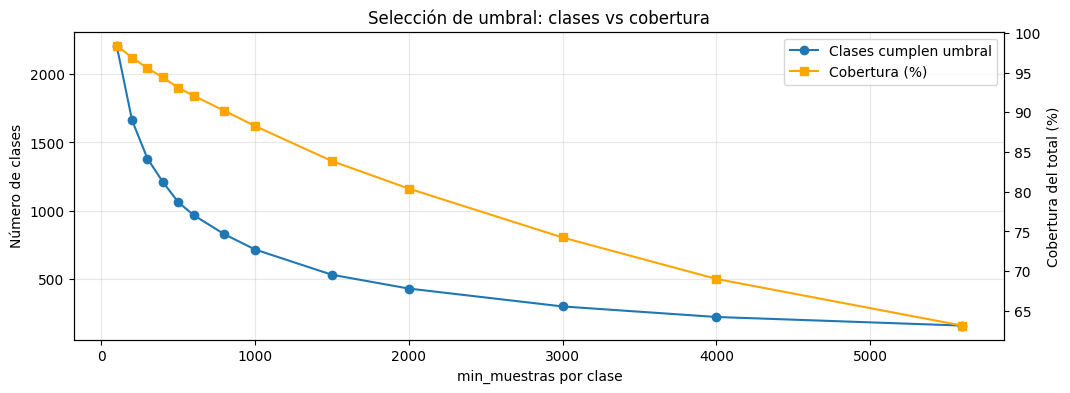

In [25]:
# Explorar umbrales
thresholds = [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 4000, 5598]

n_classes = []
coverage = []

for t in thresholds:
    keep = raw_freq_df[raw_freq_df >= t]
    n_classes.append(len(keep))
    coverage.append(keep.sum() / total_filas * 100)

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(thresholds, n_classes, marker="o", label="Clases cumplen umbral")
ax1.set_xlabel("min_muestras por clase")
ax1.set_ylabel("Número de clases")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(thresholds, coverage, marker="s", color="orange", label="Cobertura (%)")
ax2.set_ylabel("Cobertura del total (%)")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="best")

plt.title("Selección de umbral: clases vs cobertura")
plt.show()


**Notas:**
- A medida que aumenta `min_muestras` por clase, disminuye el `número de clases` que cumplen el umbral.
- La **cobertura total** cae de forma gradual:
  - Con umbrales bajos se mantiene alta, pero se reduce al exigir más ejemplos por clase.
- Se observa un **trade‑off claro**:
  - Umbrales bajos permiten muchas clases pero con menor calidad/estabilidad
  - Umbrales altos priorizan clases bien representadas pero reducen la cobertura.
- El “punto de equilibrio” visual parece estar entre **1,000 y 2,000 muestras por clase**, donde aún hay cientos de clases y una cobertura razonable.


### Definiciones

**Información**:
- Registros totales: 5.136.897
- Registros tras limpieza: 5.125.025 (se excluyen, por ejemplo, descripciones vacías: 11.872)
- **Variable objetivo**: partida_arancelaria_codigo (códigos tipo 8 dígitos, p. ej. 30061059)
- **Desbalance crítico**: con un umbral de 500 muestras por clase, hay 4.534 clases bajo ese mínimo (colas largas).
- La distribución está dominada por pocas clases (las más frecuentes superan 100k ocurrencias), mientras muchas clases aparecen pocas centenas de veces.

En este contexto, la decisión clave para maximizar éxito (accuracy/F1) es definir cuántas clases se intentará predecir (y con qué soporte por clase).


**Criterios para definir Umbrales**:
1.	Corte por cobertura acumulada (top-K clases que explican X% del total):
    - 0,70 -> 234 clases
    - 0,75 -> 312 clases
    - 0,80 -> 420 clases
    - 0,85 -> 572 clases
    - 0,90 -> 816 clases
    - 0,95 -> 1295 clases

2.	Corte por mínimo de muestras en test, asumiendo test_size = 0.2 (para que cada clase tenga suficiente evidencia en evaluación):
  - **min_test 150** -> min_train+test 750 -> 859 clases
  - **min_test 400** -> min_train+test 2000 -> 430 clases
  - **min_test 800** -> min_train+test 4000 -> 222 clases

3. **Clasificador `SVM`**
   - Propuesta: ~300 clases (rango 234–312)
     - **Opción principal** (balanceada): 312 clases (cubre ~75% del dataset).
     - **Opción alternativa** (menos costo): 234 clases (cubre ~70%).
     - **Opción alternativa por soporte estadístico**: ~300 clases si se fija `min_muestras` ≈ 3000 (derivado del análisis min_test/0.2).
   - **Justificación técnica**: en multiclase grande, SVM (aun lineal) tiende a degradar más rápido por solapamiento semántico y ruido en descripciones, y además el costo de one-vs-rest crece con #clases. Reducir a ~300 clases suele dar un salto grande en precisión y estabilidad.

4) **Clasificador `BERT`**
   - Propuesta: ~430–572 clases (recomendación operativa: 430)
     - **Opción principal** (mejor trade-off para “alto éxito”): ~430 clases, alineado con `min_muestras` ≈ 2000 (equivale a exigir ~400 ejemplos mínimos en test con test_size=0.2).
     - **Opción alternativa**: 572 clases (cubre ~85% del dataset), pero es más exigente: aumentan confusiones entre códigos cercanos y se requiere mejor normalización del texto + más cuidado con entrenamiento (scheduler, epochs, class weights/focal, etc.).
   - **Justificación técnica**: BERT captura mejor la semántica y suele sostener desempeño con más clases que SVM, si se incluyen muchas clases raras, la métrica se hunde por falta de ejemplos y por descripciones ambiguas.

**Decisión Final**:
- Foco de clasificador: “alto éxito”
- **SVM**: entrenar sobre 312 clases (cobertura ~75%).
- **BERT**: entrenar sobre 430 clases (mínimo ~2000 muestras por clase; evaluación más estable).
- Esto produce dos modelos comparables, ambos “de alta probabilidad de éxito”, pero con BERT cubriendo más taxonomía sin sacrificar tanto la calidad.


## Arquitectura

```text
    Entrada: descripción del producto
                ↓
[Filtro IN/OUT — BERT binario compartido]
                ↓
   ┌───────────────────────────────┐
   ↓                               ↓
[SVM multiclase]           [BERT multiclase]
        ↓                          ↓
   Código HS                  Código HS
        ↓                          ↓
            [Revisión Expeta]
```

## Modelo Filtro IN/OUT

### Setup Modelo

#### Parámetros

In [26]:
# Modelo base para el filtro binario

DF_NAME = "data_df"

MODEL_NAME = "bert-base-multilingual-cased"  # alternativa: "roberta-base", "xlm-roberta-base"
MAX_LENGTH = 64 # Actualizado a 64 para un mejor equilibrio entre velocidad y retención de información.
MAX_ROWS_FOR_FILTER = 400000  # ajuste según RAM/tiempo

# Split: se hará split en dos etapas: train vs temp, luego val vs test
TEST_SIZE = 0.2
N_PER_CLASS = 2000
VAL_SIZE = 0.10

# IN por TOP_K clases más frecuentes
TOP_K_IN = 430  # 312 para SVM, 430 para BERT.

# Entrenamiento
BATCH_TRAIN = 64 # Aumentado para mayor paralelismo en GPU, buscando una mayor velocidad.
BATCH_EVAL = 32
GRADIENT_ACCUMULATION_STEPS = 2 # Reducido para acelerar los pasos de entrenamiento.

LR = 2e-5
EPOCHS = 2 # Ajustado a 2 épocas para un entrenamiento inicial más rápido y menor riesgo de sobreajuste.
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06

TOKENIZERS_PARALLELISM = False
set_seed(SEED)

if TEST_MODE:
  # sobre escribe parámetros para modo test
  N_PER_CLASS = 200 # Reducir para un dataset de prueba mucho más pequeño
  TOP_K_IN = 50   # Reducir el número de clases 'IN' para test
  EPOCHS = 1      # Una sola época para una ejecución muy rápida
  print("[INFO] Modo TEST_MODE activado: N_PER_CLASS={}, TOP_K_IN={}, EPOCHS={}".format(N_PER_CLASS, TOP_K_IN, EPOCHS))

In [27]:
def preprocesar_texto(text: str) -> str:
    if text is None:
        return ""
    text = str(text)
    text = text.replace("\n", " ").replace("\r", " ")
    text = " ".join(text.split())
    return text


####  Set de Clases Objetivos

Construcción del set de clases "IN" (top-K o por cobertura)

In [28]:
print(f"[INFO] TOP_K_IN={TOP_K_IN}")
if TEST_MODE:
  filename_clases_in = "clases_ins_test.csv"
else:
  filename_clases_in = "clases_ins.csv"

path_clases_in = Path(DIR_LOG, filename_clases_in)
df_in_top_k = globals()[DF_NAME].copy()

# Normaliza tipos
df_in_top_k[COL_TEXT] = df_in_top_k[COL_TEXT].astype(str).str.strip()
df_in_top_k[COL_TEXT] = df_in_top_k[COL_TEXT].apply(preprocesar_texto)
df_in_top_k[COL_CODE] = df_in_top_k[COL_CODE].astype(str).str.strip()
df_in_top_k = df_in_top_k[df_in_top_k[COL_TEXT].str.len() > 0].copy()

vc = df_in_top_k[COL_CODE].value_counts()
clases_objetivo = vc.head(TOP_K_IN).index.tolist()

print(f"[INFO] IN classes: {len(clases_objetivo)} | cobertura aprox: {(vc.head(TOP_K_IN).sum()/vc.sum()):.4f}")

os.makedirs(path_clases_in.parent, exist_ok=True)
pd.Series(clases_objetivo, name="clases_objetivo").to_csv(path_clases_in, index=False)
print(f"[OK] Guardado: {path_clases_in}")

df_in_top_k["label_in"] = df_in_top_k[COL_CODE].isin(clases_objetivo).astype(int)
print(df_in_top_k["label_in"].value_counts(dropna=False))
print(df_in_top_k.shape)
print(df_in_top_k.columns)

[INFO] TOP_K_IN=430
[INFO] IN classes: 430 | cobertura aprox: 0.8039
[OK] Guardado: /content/drive/MyDrive/hs-code-nlp-classifier-cl/outputs/log/clases_ins.csv
label_in
1    4119753
0    1005272
Name: count, dtype: int64
(5125025, 9)
Index(['mercancia_id', 'ingreso_id', 'ingreso_detalle_id',
       'ingreso_detalle_posicion', 'mercancia_descripcion',
       'partida_arancelaria_nombre', 'partida_arancelaria_codigo',
       'len_descripcion', 'label_in'],
      dtype='object')


**Notas**:
- TOP_K_IN=430 cubre 80.39% del universo: buen punto si para calidad y cobertura.
- Distribución label_in:
  - IN 4,119,753 (80.4%) vs OUT 1,005,272 (19.6%).
  - Por el momento desbalanceado; si se entrena el filtro binario sin balanceo, tenderá a predecir IN.
  - Tamaño final: 5,125,025 filas y 9 columnas (incluye len_descripcion y label_in).

#### Limpieza y submuestreo con balance

In [29]:
# Balance dentro de IN + OUT 50/50

df_clean = df_in_top_k.copy()
df_clean[COL_TEXT] = df_clean[COL_TEXT].fillna("").astype(str).str.strip()
df_clean = df_clean[df_clean[COL_TEXT].str.len() > 0].copy()

df_in = df_clean[df_clean["label_in"] == 1]
df_out = df_clean[df_clean["label_in"] == 0]

# Balancear IN por clase HS
df_in_bal = df_in.groupby(COL_CODE, group_keys=False).apply(
    lambda x: x.sample(min(len(x), N_PER_CLASS), random_state=SEED)
)

# Balancear OUT al total de IN balanceado
df_out_bal = df_out.sample(n=min(len(df_out), len(df_in_bal)), random_state=SEED)

df_bal = pd.concat([df_in_bal, df_out_bal]).sample(frac=1, random_state=SEED).reset_index(drop=True)

print("[INFO] IN balanceado:", len(df_in_bal))
print("[INFO] OUT balanceado:", len(df_out_bal))
print(df_bal["label_in"].value_counts())
print("[INFO] Clases IN:", df_in_bal[COL_CODE].nunique())


/tmp/ipython-input-3121049272.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_in_bal = df_in.groupby(COL_CODE, group_keys=False).apply(


[INFO] IN balanceado: 860000
[INFO] OUT balanceado: 860000
label_in
0    860000
1    860000
Name: count, dtype: int64
[INFO] Clases IN: 430


**Notas**:
- Balance ok: 860k IN y 860k OUT.
- 430 clases IN con ~2,000 muestras por clase (860k / 430).
- Dataset final balanceado (1.72M filas) listo para split/entrenamiento.

#### Split train/val/test estratificado

In [30]:
# Split por índices (menos copias)
idx = df_bal.index.to_numpy()
y = df_bal["label_in"].to_numpy()

idx_trainval, idx_test = train_test_split(
    idx, test_size=TEST_SIZE, stratify=y, random_state=SEED
)

val_fraction_of_trainval = VAL_SIZE / (1 - TEST_SIZE)
y_trainval = df_bal.loc[idx_trainval, "label_in"].to_numpy()

idx_train, idx_val = train_test_split(
    idx_trainval, test_size=val_fraction_of_trainval,
    stratify=y_trainval, random_state=SEED
)

df_train = df_bal.loc[idx_train].copy()
df_val   = df_bal.loc[idx_val].copy()
df_test  = df_bal.loc[idx_test].copy()

print(f"[INFO] train={len(df_train):,} | val={len(df_val):,} | test={len(df_test):,}")
print("[INFO] Distribución label_in:")
print(" - train:", df_train["label_in"].value_counts(normalize=True).to_dict())
print(" - val:  ", df_val["label_in"].value_counts(normalize=True).to_dict())
print(" - test: ", df_test["label_in"].value_counts(normalize=True).to_dict())


[INFO] train=1,204,000 | val=172,000 | test=344,000
[INFO] Distribución label_in:
 - train: {1: 0.5, 0: 0.5}
 - val:   {1: 0.5, 0: 0.5}
 - test:  {0: 0.5, 1: 0.5}


**Notas**:
- El split generó:
  - Tamaños consistentes con 80/10/10 aprox. sobre 1.72M filas.
  - Distribución balanceada (50/50) en train/val/test.

#### Dataset + Tokenizer

In [31]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

class InOutDataset(Dataset):
    _name = None # Workaround for AttributeError with Trainer and custom torch.utils.data.Dataset

    def __init__(self, df, text_col, label_col, tokenizer, max_length):
        self.df = df.reset_index(drop=True)
        self.text_col = text_col
        self.label_col = label_col
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if isinstance(idx, list):
            texts = self.df.loc[idx, self.text_col].astype(str).tolist()
            labels = self.df.loc[idx, self.label_col].astype(int).tolist()
            enc = self.tokenizer(
                texts,
                truncation=True,
                max_length=self.max_length,
                padding=False
            )
            enc["labels"] = labels
            return enc

        text = str(self.df.at[idx, self.text_col])
        label = int(self.df.at[idx, self.label_col])
        enc = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False
        )
        enc["labels"] = label
        return enc


train_ds = InOutDataset(df_train, COL_TEXT, "label_in", tokenizer, MAX_LENGTH)
val_ds = InOutDataset(df_val, COL_TEXT, "label_in", tokenizer, MAX_LENGTH)
test_ds = InOutDataset(df_test, COL_TEXT, "label_in", tokenizer, MAX_LENGTH)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [32]:
print("[INFO] tokenizer:", MODEL_NAME)
print("[INFO] max_length:", MAX_LENGTH)

train_ds = InOutDataset(df_train, COL_TEXT, "label_in", tokenizer, MAX_LENGTH)
val_ds = InOutDataset(df_val, COL_TEXT, "label_in", tokenizer, MAX_LENGTH)
test_ds = InOutDataset(df_test, COL_TEXT, "label_in", tokenizer, MAX_LENGTH)

print("[INFO] sizes -> train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))

# Ejemplo rápido
sample = train_ds[0]
print("[INFO] sample keys:", sample.keys())
print("[INFO] sample label:", sample["labels"])
print("[INFO] sample input_ids length:", len(sample["input_ids"]))


[INFO] tokenizer: bert-base-multilingual-cased
[INFO] max_length: 64
[INFO] sizes -> train: 1204000 val: 172000 test: 344000
[INFO] sample keys: KeysView({'input_ids': [101, 160, 11259, 27128, 11274, 66014, 11537, 93280, 11273, 132, 153, 39272, 71655, 32995, 24093, 132, 25067, 157, 11259, 15417, 28895, 11403, 25067, 153, 69849, 60493, 117, 32349, 29990, 145, 37079, 11274, 66014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 1})
[INFO] sample label: 1
[INFO] sample input_ids length: 34


In [33]:
print("[INFO] sample text:", df_train.iloc[0][COL_TEXT])


[INFO] sample text: WEINBRENNER; POLIESTER; DE TEJIDO DE PUNTO, PARA HOMBRE


### Modelo BERT binario

#### Definición

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label={0: "OUT", 1: "IN"},
    label2id={"OUT": 0, "IN": 1}
)
model.to(device)
print(model)
print(device)
print("[INFO] num_labels:", model.config.num_labels)
print("[INFO] id2label:", model.config.id2label)

num_params = sum(p.numel() for p in model.parameters())
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("[INFO] params:", f"{num_params:,}")
print("[INFO] trainable:", f"{num_trainable:,}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [35]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    # Calcula Accuracy
    accuracy = accuracy_score(labels, preds)

    # Calcula Precision, Recall, F1-Score para ambas clases (o puedes especificar pos_label=1 para la clase 'IN')
    # 'average=weighted' considera el desbalance de clases (si lo hubiera, aunque aquí es 50/50)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


#### Argumentos de entrenamiento

In [36]:

print("transformers.__version__ =", transformers.__version__)
print("TrainingArguments module  =", TrainingArguments.__module__)
print("TrainingArguments file    =", inspect.getsourcefile(TrainingArguments))
print("TrainingArguments init sig=", inspect.signature(TrainingArguments.__init__))


transformers.__version__ = 4.57.3
TrainingArguments module  = transformers.training_args
TrainingArguments file    = /usr/local/lib/python3.12/dist-packages/transformers/training_args.py
TrainingArguments init sig= (self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: float = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0

In [37]:
training_args = TrainingArguments(
    output_dir=str(Path(DIR_MODELS) / "tmp_inout"),

    eval_strategy="epoch", # Habilitado para evaluación al final de cada época
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=100,

    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,

    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,

    dataloader_num_workers=4, # Aumentado para acelerar la carga de datos
    dataloader_pin_memory=True, # Habilitado para una transferencia de datos más rápida a la GPU

    fp16=True, # Ajuste para acelerar el entrenamiento en GPU
    bf16=False,

    report_to="none",
    disable_tqdm=False,
    remove_unused_columns=False, # Deshabilitado para resolver el AttributeError con custom InOutDataset
    seed=SEED,
)

In [38]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
print(trainer)
print("[INFO] train_dataset:", len(trainer.train_dataset))
print("[INFO] eval_dataset:", len(trainer.eval_dataset))
print("[INFO] batch_size_train:", training_args.per_device_train_batch_size)
print("[INFO] batch_size_eval:", training_args.per_device_eval_batch_size)

[INFO] train_dataset: 1204000
[INFO] eval_dataset: 172000
[INFO] batch_size_train: 64
[INFO] batch_size_eval: 32


Calculo de steps

In [40]:
# Steps por época (aprox)
train_steps_per_epoch = len(trainer.train_dataset) // (
    training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps
)
eval_steps = len(trainer.eval_dataset) // training_args.per_device_eval_batch_size

print("[INFO] train steps/epoch:", train_steps_per_epoch)
print("[INFO] eval steps:", eval_steps)

[INFO] train steps/epoch: 9406
[INFO] eval steps: 5375


**Notas:**
- train steps/epoch = 18,812: número de actualizaciones por época (tiempo por época).
- eval steps = 1,343: número de batches en validación (determina cuánto tarda evaluar).

### Entrenamiento

In [41]:
# Si el modelo lo permite: gradient checkpointing reduce memoria (a costa de tiempo)
try:
    trainer.model.gradient_checkpointing_enable()
    trainer.model.config.use_cache = False  # importante para evitar uso extra de memoria
    print("[INFO] gradient_checkpointing habilitado.")
except Exception as e:
    print("[WARN] No se pudo habilitar gradient_checkpointing:", e)

# Limpieza para soporte MAC
gc.collect()
if torch.backends.mps.is_available():
    try:
        torch.mps.empty_cache()
    except Exception:
        pass

    #  Ajustes de estabilidad para Mac
    if hasattr(trainer, "args") and trainer.args is not None:
        # Evitar multiproceso en dataloaders
        trainer.args.dataloader_num_workers = 0
        trainer.args.dataloader_pin_memory = False

        # Bajar eval batch para reducir peak de memoria (si eval ocurre)
        if getattr(trainer.args, "per_device_eval_batch_size", None) is not None:
            trainer.args.per_device_eval_batch_size = min(int(trainer.args.per_device_eval_batch_size), 16)

        # Logging estable
        trainer.args.disable_tqdm = False
        trainer.args.report_to = "none"


[INFO] gradient_checkpointing habilitado.


In [42]:
if TEST_MODE:
  BACKUP_DIR = Path(DIR_MODELS) / "bert_inout_ckpt_test"
else:
  BACKUP_DIR = Path(DIR_MODELS) / "bert_inout_ckpt_final"

TRAIN_OUT_PATH = BACKUP_DIR / "train_output.json"
TRAIN_ARGS_PATH = BACKUP_DIR / "training_args.json"


if BACKUP_DIR.exists() and not TEST_MODE:
    print("[INFO] Modelo FINAL ya existe, cargando...")
    if ("model" in globals()) and ("tokenizer" in globals()):
        print("[INFO] Reutilizando modelo/tokenizer ya cargados en memoria.")
    else:
        tokenizer = AutoTokenizer.from_pretrained(str(BACKUP_DIR), use_fast=True)
        model = AutoModelForSequenceClassification.from_pretrained(str(BACKUP_DIR), low_cpu_mem_usage=True)

    try:
        trainer.model = model
    except Exception:
        pass

    if TRAIN_OUT_PATH.exists():
        with open(TRAIN_OUT_PATH, "r", encoding="utf-8") as f:
            train_metrics = json.load(f)
        print("[INFO] train metrics (loaded):", train_metrics)

else:
    print("[INFO] Inicio de entrenamiento...")
    print(" - epochs:", trainer.args.num_train_epochs)
    print(" - batch_train:", trainer.args.per_device_train_batch_size)
    print(" - grad_accum:", trainer.args.gradient_accumulation_steps)
    print(" - lr:", trainer.args.learning_rate)

    train_output = trainer.train()

    print("[INFO] Entrenamiento terminado.")
    print(" - train_output.metrics:", train_output.metrics)

    # Guardar artefactos finales
    BACKUP_DIR.mkdir(parents=True, exist_ok=True)
    trainer.save_model(str(BACKUP_DIR))
    tokenizer.save_pretrained(str(BACKUP_DIR))

    with open(TRAIN_OUT_PATH, "w", encoding="utf-8") as f:
        json.dump(train_output.metrics, f, ensure_ascii=False, indent=2)

    with open(TRAIN_ARGS_PATH, "w", encoding="utf-8") as f:
        json.dump(
            {
                "bert_base": getattr(tokenizer, "name_or_path", None),
                "max_length": globals().get("MAX_LENGTH", None),
                "num_train_epochs": trainer.args.num_train_epochs,
                "per_device_train_batch_size": trainer.args.per_device_train_batch_size,
                "per_device_eval_batch_size": trainer.args.per_device_eval_batch_size,
                "gradient_accumulation_steps": trainer.args.gradient_accumulation_steps,
                "learning_rate": trainer.args.learning_rate,
                "weight_decay": trainer.args.weight_decay,
                "warmup_ratio": getattr(trainer.args, "warmup_ratio", None),
                "seed": trainer.args.seed,
                "fp16": getattr(trainer.args, "fp16", False),
                "dataloader_num_workers": trainer.args.dataloader_num_workers,
                "gradient_checkpointing": True,
            },
            f,
            ensure_ascii=False,
            indent=2
        )

    print(f"[OK] Modelo FINAL guardado en: {BACKUP_DIR}")
    print(f"[OK] Métricas guardadas en: {TRAIN_OUT_PATH}")
    print(f"[OK] Training args guardados en: {TRAIN_ARGS_PATH}")


[INFO] Inicio de entrenamiento...
 - epochs: 2
 - batch_train: 64
 - grad_accum: 2
 - lr: 2e-05


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.291300,0.265531,0.002800,0.887680,0.888696,0.887680,0.887607
2,0.234400,0.218809,0.002800,0.906692,0.907834,0.906692,0.906626


[INFO] Entrenamiento terminado.
 - train_output.metrics: {'train_runtime': 8381.1437, 'train_samples_per_second': 287.312, 'train_steps_per_second': 2.245, 'total_flos': 7.677902906447616e+16, 'train_loss': 0.3207391340040408, 'epoch': 2.0}
[OK] Modelo FINAL guardado en: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/bert_inout_ckpt_final
[OK] Métricas guardadas en: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/bert_inout_ckpt_final/train_output.json
[OK] Training args guardados en: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/bert_inout_ckpt_final/training_args.json


**Notas**
- Duración del Entrenamiento:
  - TEST_MODE (1 época): Aproximadamente 47 segundos.
  - Entrenamiento Completo (2 épocas): Aproximadamente 2 horas, 19 minutos y 40 segundos

- Métricas entrenamiento:
| Métrica	| TEST_MODE | Entrenamiento Completo (1ª Época)	| Entrenamiento Completo (2ª Época) |
|---------|-----------|-----------|---------|
| Validation Loss	| 0.443| 0.265531 | 0.218809 |
| Accuracy| 79.65% | 88.77% | 90.67% |
| Precision | 80.13% | 88.87% | 90.78% |
| Recall | 79.65% | 88.77% | 90.67% |
| F1-score | 79.56% | 88.76% | 90.66% |

- Reducción Significativa de la Pérdida: La Validation Loss ha disminuido drásticamente desde 0.443 en TEST_MODE a 0.2188 al final del entrenamiento completo, indicando que el modelo ha aprendido mucho más y generaliza mejor.
- Mejora Consistente en Métricas: Todas las métricas de rendimiento (Accuracy, Precision, Recall, F1-score) han mejorado en aproximadamente 10 puntos porcentuales, pasando de ~80% en TEST_MODE a ~90.6% en el entrenamiento completo.
- Aprendizaje entre Épocas: Se observa una mejora clara del rendimiento desde la primera a la segunda época del entrenamiento completo, lo que sugiere que las 2 épocas fueron beneficiosas y que el modelo siguió aprendiendo y ajustándose en la segunda época.




### Evaluación


Para evaluar el modelo, primero se obtendrán las predicciones sobre test_ds utilizando trainer.predict(). Luego, se extraerán las etiquetas predichas y las etiquetas reales. Estas se utilizarán en pasos posteriores para generar un informe de clasificación y una matriz de confusión, con el fin de comprender el desempeño del modelo, poniendo especial énfasis en el recall de la clase “OUT”

##### Predicciones del Modelo

In [43]:
predicciones_output = trainer.predict(test_ds)
predictions = predicciones_output.predictions
true_labels = predicciones_output.label_ids

# logits a predicted labels (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

print("[INFO] Predicciones obtenidas.")
print(f" - Shape de predicciones (logits): {predictions.shape}")
print(f" - Shape de true labels: {true_labels.shape}")
print(f" - Shape de predicted labels: {predicted_labels.shape}")

# Store for later use
globals().update(locals())

[INFO] Predicciones obtenidas.
 - Shape de predicciones (logits): (344000, 2)
 - Shape de true labels: (344000,)
 - Shape de predicted labels: (344000,)


##### Reporte de Clasificación

In [44]:
target_names = ['OUT', 'IN']

report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("[INFO] Classification Report:")
print(report)

# Store for later use
globals().update(locals())

[INFO] Classification Report:
              precision    recall  f1-score   support

         OUT       0.93      0.88      0.90    172000
          IN       0.89      0.93      0.91    172000

    accuracy                           0.91    344000
   macro avg       0.91      0.91      0.91    344000
weighted avg       0.91      0.91      0.91    344000



**Notas**:

- Métricas por Clase:
  - **Clase 'OUT' (label 0)**:
    - Precision: 0.93 (93%):
      De todas las instancias que el modelo predijo como 'OUT', el 93% fueron correctamente clasificadas como 'OUT'. Esto indica una baja tasa de falsos positivos (ítems 'IN' que fueron erróneamente clasificados como 'OUT').
    - Recall: 0.88 (88%):
      De todas las instancias que eran realmente 'OUT', el modelo logró identificar correctamente el 88%. Esto significa que el 12% de los ítems 'OUT' fueron pasados por alto (falsos negativos).
    - F1-score: 0.90 (90%):
      Es una medida equilibrada de precisión y recall para la clase 'OUT'.
    - Support: 172000:
      Número total de instancias de la clase 'OUT' en el conjunto de prueba.

  - **Clase 'IN' (label 1)**:
    - Precision: 0.89 (89%):
      De todas las instancias que el modelo predijo como 'IN', el 89% fueron correctamente clasificadas como 'IN'.
    - Recall: 0.93 (93%):
      De todas las instancias que eran realmente 'IN', el modelo identificó correctamente el 93%. Esto sugiere que el modelo es muy bueno detectando los ítems 'IN'.
    - F1-score: 0.91 (91%):
      Medida equilibrada de precisión y recall para la clase 'IN'.
    - Support: 172000:
      Número total de instancias de la clase 'IN' en el conjunto de prueba.

- Métricas Globales:
  - **Accuracy**: 0.91 (91%): La precisión general del modelo es del 91%, indicando que el 91% de todas las predicciones fueron correctas.
  - **Macro Avg**:
    Promedios no ponderados de las métricas por clase. Proporcionan una visión de cómo se desempeña el modelo en ambas clases sin considerar el desbalance (aunque en este caso, las clases están balanceadas).
    - Precision: 0.91
    - Recall: 0.91
    - F1-score: 0.91
  - **Weighted Avg**:
    Promedios ponderados por el número de instancias de cada clase. En este caso, al estar balanceadas, los valores son muy similares a los de macro avg y accuracy.
    - Precision: 0.91
    - Recall: 0.91
    - F1-score: 0.91

El modelo demuestra un rendimiento alto y balanceado para ambas clases. El alto Recall para la clase 'IN' (0.93) es muy positivo, ya que el modelo es altamente efectivo en identificar correctamente los productos que pertenecen a las categorías principales. El Recall de la clase 'OUT' (0.88) es también muy sólido, sugiriendo una buena capacidad para identificar ítems que requieren revisión adicional.

La Accuracy general del 91% confirma la robustez del clasificador. Los F1-scores consistentemente altos para ambas clases y en los promedios (macro avg, weighted avg) refuerzan la idea de que el modelo mantiene un buen equilibrio entre Precision y Recall.

Este reporte confirma que el modelo IN/OUT es un filtro efectivo, cumpliendo con las expectativas de un rendimiento robusto después del entrenamiento completo.



##### Matriz de Confusión

[INFO] Matriz de Confusión:
[[151309  20691]
 [ 11531 160469]]


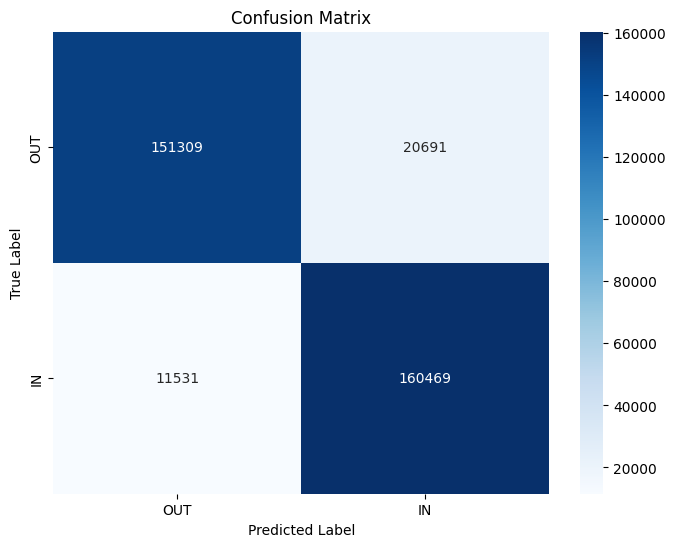

In [45]:
cm = confusion_matrix(true_labels, predicted_labels)

print("[INFO] Matriz de Confusión:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Store for later use
globals().update(locals())

**Notas**:
- Verdaderos Negativos (TN) - [151309]:
    Instancias que son realmente 'OUT' y fueron correctamente clasificadas como 'OUT'.
- Falsos Positivos (FP) - [20691]:
    Instancias que son realmente 'IN' pero fueron incorrectamente clasificadas como 'OUT'.
- Falsos Negativos (FN) - [11531]:
    Instancias que son realmente 'OUT' pero fueron incorrectamente clasificadas como 'IN'.
- Verdaderos Positivos (TP) - [160469]:
    Instancias que son realmente 'IN' y fueron correctamente clasificadas como 'IN'.
- Alto número de Verdaderos Positivos y Negativos:
    El modelo demuestra una fuerte capacidad para identificar correctamente tanto los elementos 'IN' como los 'OUT'.
  - 151.309 descripciones fueron correctamente identificadas como 'OUT'.
  - 160.469 descripciones fueron correctamente identificadas como 'IN'.
- Manejo de Errores:
  - Falsos Positivos (FP) - 20.691: Estos son elementos que el modelo predijo como 'OUT' (es decir, que requieren revisión), pero que en realidad eran 'IN'. En el contexto de un filtro, esto significa que se enviarán a revisión algunos elementos que no la necesitaban, lo que podría generar trabajo extra pero no un riesgo de pasar por alto un elemento crítico.
  - Falsos Negativos (FN) - 11.531: Estos son elementos que el modelo predijo como 'IN' (es decir, que no requieren revisión), pero que en realidad eran 'OUT'. Este es el tipo de error más crítico para un filtro de riesgo, ya que representa elementos 'OUT' que el sistema debería haber detectado pero que el modelo dejó pasar como 'IN'.
- La matriz de confusión confirma el alto rendimiento general del modelo.
- El número de Falsos Negativos (11.531) es relativamente bajo en comparación con el total de instancias y los Verdaderos Positivos, lo cual es positivo para un filtro de riesgo.
- El balance entre los errores indica que el modelo es bastante robusto. Sin embargo, para un filtro de riesgo, el objetivo principal es minimizar los Falsos Negativos (FN, es decir, maximizar el Recall(OUT)). Si el número actual de FN se considera demasiado alto para la aplicación crítica, se podría explorar el ajuste del umbral de clasificación para ser más conservador y clasificar más casos como 'OUT' (incluso si eso implica un aumento en los - Falsos Positivos), dependiendo de la tolerancia al riesgo.

Posibilidades de mejora:
- **Política de decisión:
  - Versión 1:
    - predicted_labels = argmax(logits)
    - Equivale a usar un umbral fijo 0.5 sobre P(IN) sin calibración.
  - Ajustes:
    - calcular probabilidades P(IN)
    - elegir un umbral τ para cumplir Recall(OUT) objetivo
    - guardar τ como artefacto (thresholds.json) y aplicarlo en inferencia
    - Esto suele subir Recall(OUT) de forma significativa a costa de bajar algo de Recall(IN), que es exactamente el trade-off deseado para minimizar errores de clasificación multiclase fuera de dominio.


### Calibración

##### Ajustes

In [47]:
# Dataset para calibración: val_ds
pred_out = trainer.predict(val_ds)
logits = pred_out.predictions
y_true = pred_out.label_ids  # 0=OUT, 1=IN

# probabilidades
proba_in = torch.softmax(torch.tensor(logits), dim=-1).numpy()[:, 1]
proba_out = 1.0 - proba_in

In [48]:

# alto Recall(OUT) => tratamos OUT como clase positiva para calibrar umbral sobre proba_out
y_out = (y_true == 0).astype(int)

TARGET_RECALL_OUT = 0.97  # ajuste según SLA (0.95–0.98)
prec, rec, thr = precision_recall_curve(y_out, proba_out)

best = None
for i in range(len(thr)):
    if rec[i] >= TARGET_RECALL_OUT:
        cand = (thr[i], prec[i], rec[i])
        # max precision OUT sujeto a recall OUT mínimo
        if (best is None) or (cand[1] > best[1]):
            best = cand

if best is None:
    # fallback: el umbral que maximiza recall (si no se alcanza target)
    i_best = int(np.argmax(rec[:-1]))
    best = (thr[i_best], prec[i_best], rec[i_best])

tau_out = float(best[0])      # umbral sobre P(OUT)
tau_in  = float(1.0 - tau_out)

print(f"[OK] Umbral calibrado: tau_in={tau_in:.4f} (equiv tau_out={tau_out:.4f})")
print(f"[INFO] Precision_OUT={best[1]:.4f} | Recall_OUT={best[2]:.4f}")


[OK] Umbral calibrado: tau_in=0.8008 (equiv tau_out=0.1992)
[INFO] Precision_OUT=0.7997 | Recall_OUT=0.9700


##### Reporte con umbral τ

In [49]:
# Reporte con umbral τ
y_pred = (proba_in >= tau_in).astype(int)
print(classification_report(y_true, y_pred, target_names=["OUT","IN"], digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         OUT     0.7998    0.9699    0.8767     86000
          IN     0.9617    0.7572    0.8473     86000

    accuracy                         0.8635    172000
   macro avg     0.8808    0.8635    0.8620    172000
weighted avg     0.8808    0.8635    0.8620    172000

Confusion matrix:
 [[83408  2592]
 [20880 65120]]


##### Matriz de confusión

[INFO] Matriz de Confusión:
[[83408  2592]
 [20880 65120]]


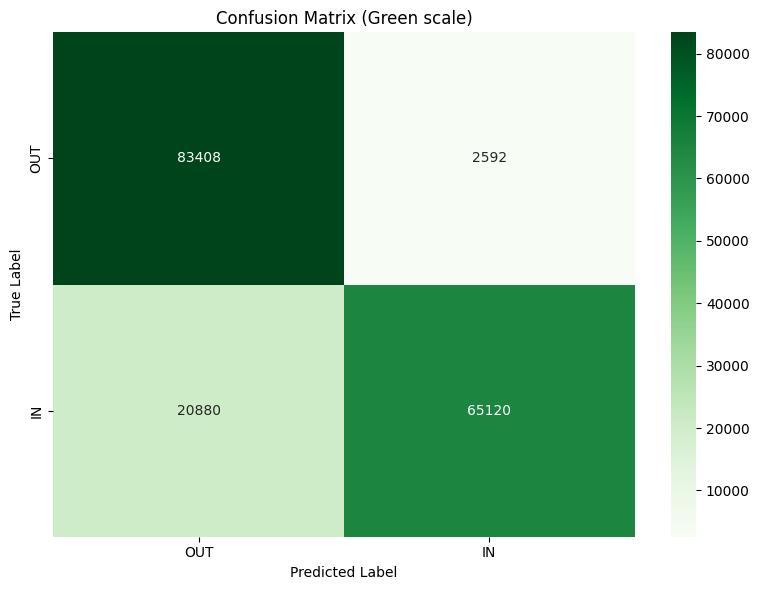

In [54]:
# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

print("[INFO] Matriz de Confusión:")
print(cm)

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',          # ← escala de verdes
    xticklabels=target_names,
    yticklabels=target_names,
    cbar=True
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Green scale)')
plt.tight_layout()
plt.show()

# Store for later use (mantiene compatibilidad con su notebook)
globals().update(locals())

##### Backup Ajustes

In [187]:
# Guardar umbral en Drive (junto al modelo)

BACKUP_DIR = Path(DIR_MODELS) / "bert_inout_ckpt_final"
BACKUP_DIR.mkdir(parents=True, exist_ok=True)

ts = datetime.now().strftime("%Y%m%d_%H%M%S")

thresholds = {
    "tau_in": tau_in,
    "tau_out": tau_out,
    "target_recall_out": TARGET_RECALL_OUT,
    "calibration_split": "val",
    "calibrated_at": ts,
}

# Guardar el umbral con la versión de timestamp
out_path_versioned = BACKUP_DIR / f"thresholds_{ts}.json"
with open(out_path_versioned, "w", encoding="utf-8") as f:
    json.dump(thresholds, f, ensure_ascii=False, indent=2)
print(f"[OK] Umbral versionado guardado en: {out_path_versioned}")

# Guardar una copia del umbral con el nombre genérico 'thresholds.json' para facilitar la carga
out_path_generic = BACKUP_DIR / "thresholds.json"
with open(out_path_generic, "w", encoding="utf-8") as f:
    json.dump(thresholds, f, ensure_ascii=False, indent=2)
print(f"[OK] Umbral genérico guardado en: {out_path_generic}")

[OK] Umbral versionado guardado en: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/bert_inout_ckpt_final/thresholds_20260120_111800.json
[OK] Umbral genérico guardado en: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/bert_inout_ckpt_final/thresholds.json


### Clasificación multiclase

In [55]:
TEST_MODE = True

#### Dataset multiclase para la capa IN

In [56]:

# Cargar clases objetivo desde el artefacto generado
path_clases_in = Path(DIR_LOG) / ("clases_ins_test.csv" if TEST_MODE else "clases_ins.csv")
clases_objetivo = pd.read_csv(path_clases_in)["clases_objetivo"].astype(str).tolist()
clases_set = set(clases_objetivo)

df_mc = df_in_top_k.copy()
df_mc[COL_CODE] = df_mc[COL_CODE].astype(str).str.strip()
df_mc = df_mc[df_mc[COL_CODE].isin(clases_set)].copy()

# Etiqueta multiclase: el código HS dentro del set objetivo
df_mc["label_code"] = df_mc[COL_CODE].astype(str)

print("[INFO] registros IN (multiclase):", len(df_mc))
print("[INFO] clases:", df_mc["label_code"].nunique())
print(df_mc["label_code"].value_counts().head(10))

[INFO] registros IN (multiclase): 2180000
[INFO] clases: 50
label_code
30061059    126200
90213990    124172
90189089    109399
33041000    107284
84439990     96314
33042000     81872
84314320     75728
33049990     74860
33059090     70094
84733000     57488
Name: count, dtype: int64


#### Split estratificado por código HS

In [57]:
SEED = int(SEED)

# (Opcional) cap por clase para limitar tamaño y evitar sesgos extremos
N_PER_CLASS_MC = 2000
df_mc_bal = df_mc.groupby("label_code", group_keys=False).apply(
    lambda x: x.sample(min(len(x), N_PER_CLASS_MC), random_state=SEED)
).reset_index(drop=True)

# Split train/val/test estratificado por label_code
df_trainval, df_test_mc = train_test_split(
    df_mc_bal,
    test_size=0.20,
    stratify=df_mc_bal["label_code"],
    random_state=SEED
)
df_train_mc, df_val_mc = train_test_split(
    df_trainval,
    test_size=0.10 / 0.80,  # val=10% total
    stratify=df_trainval["label_code"],
    random_state=SEED
)

print("[INFO] train_mc:", len(df_train_mc), "| val_mc:", len(df_val_mc), "| test_mc:", len(df_test_mc))
print("[INFO] clases train:", df_train_mc["label_code"].nunique())

/tmp/ipython-input-3385288075.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mc_bal = df_mc.groupby("label_code", group_keys=False).apply(


[INFO] train_mc: 70000 | val_mc: 10000 | test_mc: 20000
[INFO] clases train: 50


### Modelo SVM multiclase

#### Parámetros

In [132]:
NGRAM_RANGE=(1,2)
MIN_DF=5
MAX_FEATURES=300000
SUBLINEAR_TF=True

# Umbral de abstención (calibrar)
TAU_MARGIN = 0.5  # valor inicial, calibrar en val

if TEST_MODE:
    NGRAM_RANGE = (1,1)
    MIN_DF = 3
    MAX_FEATURES = 10000
    print("[INFO] TEST_MODE = True: SVM parameters adjusted for quick training.")

print(f"[INFO] Final SVM NGRAM_RANGE: {NGRAM_RANGE}")
print(f"[INFO] Final SVM MIN_DF: {MIN_DF}")
print(f"[INFO] Final SVM MAX_FEATURES: {MAX_FEATURES}")

[INFO] TEST_MODE = True: SVM parameters adjusted for quick training.
[INFO] Final SVM NGRAM_RANGE: (1, 1)
[INFO] Final SVM MIN_DF: 3
[INFO] Final SVM MAX_FEATURES: 10000


(TF-IDF + LinearSVC o SGDClassifier)

#### Preprocesamiento

In [133]:
def preprocesar_texto_svm(texto: str) -> str:
    if texto is None:
        return ""

    t = str(texto)

    # Normalizar unicode (acentos y símbolos consistentes)
    t = unicodedata.normalize("NFKC", t)

    # Minúsculas
    t = t.lower()

    # Reemplazar saltos de línea y tabs por espacio
    t = re.sub(r"[\r\n\t]+", " ", t)

    # Colapsar espacios múltiples
    t = re.sub(r"\s{2,}", " ", t).strip()

    # Opcional: eliminar caracteres no imprimibles
    #t = re.sub(r"[^\x20-\x7EáéíóúñüÁÉÍÓÚÑÜ]", " ", t)

    return t


def prep_text_series(s: pd.Series, name: str = "") -> pd.Series:
    print(f"[INFO] Preprocesando texto para: {name}")
    print(f"  - Registros totales: {len(s)}")

    n_null = s.isna().sum()
    print(f"  - Valores nulos: {n_null}")

    s_proc = s.fillna("").astype(str).map(preprocesar_texto_svm)

    # Estadísticas básicas
    empty_after = (s_proc.str.len() == 0).sum()
    print(f"  - Textos vacíos tras preprocesamiento: {empty_after}")

    # Longitud media (tokens aproximados por espacios)
    avg_len = s_proc.str.split().map(len).mean()
    print(f"  - Longitud media (tokens aprox): {avg_len:.1f}")

    return s_proc

##### Preparación TRAIN

In [134]:
# Preparación TRAIN
SVM_X_train = prep_text_series(df_train_mc[COL_TEXT], name="TRAIN")
SVM_y_train = df_train_mc["label_code"].astype(str)

print(f"[INFO] TRAIN labels:")
print(f"  - Clases únicas: {SVM_y_train.nunique()}")
print(f"  - Ejemplos por clase (top 5):")
print(SVM_y_train.value_counts().head())

[INFO] Preprocesando texto para: TRAIN
  - Registros totales: 70000
  - Valores nulos: 0
  - Textos vacíos tras preprocesamiento: 0
  - Longitud media (tokens aprox): 7.4
[INFO] TRAIN labels:
  - Clases únicas: 50
  - Ejemplos por clase (top 5):
label_code
84314900    1400
33049100    1400
64041100    1400
85176210    1400
38221900    1400
Name: count, dtype: int64


##### Preparación VALIDATION

In [135]:
SVM_X_val = prep_text_series(df_val_mc[COL_TEXT], name="VAL")
SVM_y_val = df_val_mc["label_code"].astype(str)

print(f"[INFO] VAL labels:")
print(f"  - Clases únicas: {SVM_y_val.nunique()}")
print(f"  - Ejemplos por clase (top 5):")
print(SVM_y_val.value_counts().head())

[INFO] Preprocesando texto para: VAL
  - Registros totales: 10000
  - Valores nulos: 0
  - Textos vacíos tras preprocesamiento: 0
  - Longitud media (tokens aprox): 7.4
[INFO] VAL labels:
  - Clases únicas: 50
  - Ejemplos por clase (top 5):
label_code
84733000    200
90211000    200
85365090    200
85444200    200
84314900    200
Name: count, dtype: int64


##### Definición del pipeline SVM

In [136]:
print("[INFO] Inicializando pipeline SVM + TF-IDF")
print("  - ngram_range: (1,2)")
print("  - min_df: 3")
print("  - max_df: 0.95")
print("  - max_features: 300000")
print("  - sublinear_tf: True")

svm_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=NGRAM_RANGE,
        min_df=MIN_DF,
        max_df=MAX_DF,
        max_features=MAX_FEATURES,
        sublinear_tf=SUBLINEAR_TF
    )),
    ("svm", LinearSVC())
])

print("[OK] Pipeline SVM listo para entrenamiento")

[INFO] Inicializando pipeline SVM + TF-IDF
  - ngram_range: (1,2)
  - min_df: 3
  - max_df: 0.95
  - max_features: 300000
  - sublinear_tf: True
[OK] Pipeline SVM listo para entrenamiento


##### Entrenamiento

In [142]:
t0 = time.time()
start_time_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"[INFO] Iniciando entrenamiento SVM multiclase (TF-IDF + LinearSVC) en {start_time_str}...")
print(f" - Dataset TRAIN: {len(SVM_X_train)} muestras, {SVM_y_train.nunique()} clases.")
print(f" - Parámetros TF-IDF: NGRAM_RANGE={NGRAM_RANGE}, MIN_DF={MIN_DF}, MAX_FEATURES={MAX_FEATURES}")

svm_clf.fit(SVM_X_train, SVM_y_train)

dt = time.time() - t0
end_time_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"[INFO] Entrenamiento SVM completado en {dt:.1f} segundos. Finalizado en {end_time_str}.")


[INFO] Iniciando entrenamiento SVM multiclase (TF-IDF + LinearSVC) en 2026-01-20 10:19:47...
 - Dataset TRAIN: 70000 muestras, 50 clases.
 - Parámetros TF-IDF: NGRAM_RANGE=(1, 1), MIN_DF=3, MAX_FEATURES=10000
[INFO] Entrenamiento SVM completado en 11.7 segundos. Finalizado en 2026-01-20 10:19:59.


##### Validación

In [143]:
print("[INFO] Evaluación SVM multiclase – VALIDATION")

t0 = time.time()
SVM_y_pred = svm_clf.predict(SVM_X_val)
dt = time.time() - t0

SVM_acc = accuracy_score(SVM_y_val, SVM_y_pred)
SVM_mf1 = f1_score(SVM_y_val, SVM_y_pred, average="macro")

SVM_n_samples = len(SVM_y_val)
SVM_n_classes = len(set(SVM_y_val))

print(f"[INFO] Predicción completada en {dt:.2f}s")
print(f" - Muestras evaluadas : {SVM_n_samples}")
print(f" - Clases evaluadas : {SVM_n_classes}")

print(f" - Accuracy (val): {SVM_acc:.4f}")
print(f" - Macro F1 (val): {SVM_mf1:.4f}")

print("[INFO] Classification report (VAL):")
print(classification_report(SVM_y_val, SVM_y_pred, digits=4))


[INFO] Evaluación SVM multiclase – VALIDATION
[INFO] Predicción completada en 0.08s
 - Muestras evaluadas : 10000
 - Clases evaluadas : 50
 - Accuracy (val): 0.8414
 - Macro F1 (val): 0.8415
[INFO] Classification report (VAL):
              precision    recall  f1-score   support

    30061059     0.9749    0.9700    0.9724       200
    33030010     0.7980    0.7900    0.7940       200
    33030020     0.7681    0.7950    0.7813       200
    33041000     0.9583    0.9200    0.9388       200
    33042000     0.9694    0.9500    0.9596       200
    33043020     0.9803    0.9950    0.9876       200
    33049100     0.8125    0.9100    0.8585       200
    33049980     0.8261    0.8550    0.8403       200
    33049990     0.7542    0.6750    0.7124       200
    33051010     0.9348    0.8600    0.8958       200
    33059020     0.7475    0.7550    0.7512       200
    33059030     0.9655    0.9800    0.9727       200
    33059090     0.7571    0.7950    0.7756       200
    38221900    

#### Abstención por margen

In [139]:
# scores: (n_samples, n_classes)
SVM_scores = svm_clf.decision_function(SVM_X_val)

# Mejor clase y su score
SVM_best_idx = np.argmax(SVM_scores, axis=1)
SVM_best_score = SVM_scores[np.arange(len(SVM_best_idx)), SVM_best_idx]

# Segundo mejor score para margen (mejor - segundo)
SVM_scores_sorted = np.sort(SVM_scores, axis=1)
SVM_second_score = SVM_scores_sorted[:, -2]
SVM_margin = SVM_best_score - SVM_second_score

SVM_pred_labels = svm_clf.classes_[SVM_best_idx]
SVM_pred_labels_abstain = SVM_pred_labels.copy()
SVM_pred_labels_abstain[SVM_margin < TAU_MARGIN] = "UNSURE"

print("[INFO] % abstención:", (SVM_pred_labels_abstain == "UNSURE").mean())


[INFO] % abstención: 0.1491


In [144]:
# Reporte solo sobre los casos no-abstenidos
SVM_mask = SVM_pred_labels_abstain != "UNSURE"
print("[INFO] Evaluación sin abstenidos (solo predicciones confiables):")
print(classification_report(SVM_y_val[SVM_mask], SVM_pred_labels_abstain[SVM_mask], digits=4))



[INFO] Evaluación sin abstenidos (solo predicciones confiables):
              precision    recall  f1-score   support

    30061059     0.9898    0.9949    0.9923       195
    33030010     0.8725    0.8609    0.8667       151
    33030020     0.8377    0.8836    0.8600       146
    33041000     0.9779    0.9620    0.9699       184
    33042000     0.9787    0.9583    0.9684       192
    33043020     0.9950    0.9950    0.9950       200
    33049100     0.8508    0.9565    0.9006       161
    33049980     0.8805    0.8974    0.8889       156
    33049990     0.8468    0.7394    0.7895       142
    33051010     0.9758    0.9360    0.9555       172
    33059020     0.8444    0.9048    0.8736       126
    33059030     0.9948    0.9948    0.9948       191
    33059090     0.9286    0.9028    0.9155       144
    38221900     0.9950    1.0000    0.9975       199
    39269090     0.9401    0.8771    0.9075       179
    40169390     0.9497    0.9392    0.9444       181
    42029220    

**Notas**:
- La interpretación correcta de este resultado espositiva, y confirma que la abstención por margen está cumpliendo exactamente su propósito dentro de la arquitectura.
- Es el desempeño del SVM solo sobre los casos en los que decidió predecir, es decir: “Predicciones confiables” = casos con margen ≥ τ
  - Macro-F1 ≈ 0.91
    - Alto para HS multiclase real
    - Indica buen desempeño transversal, no solo en clases frecuentes
	  - Accuracy ≈ 0.91; Correcto, pero secundaria (macro-F1 es la métrica relevante)


#### Matriz de confusión

In [145]:
# Matriz de confusión (sin UNSURE)
print(confusion_matrix(SVM_y_val[SVM_mask], SVM_pred_labels_abstain[SVM_mask], labels=svm_clf.classes_))

[[194   0   0 ...   0   0   0]
 [  0 130  20 ...   0   0   0]
 [  0  17 129 ...   0   0   0]
 ...
 [  0   0   0 ... 177   1   0]
 [  0   0   0 ...   2 171  13]
 [  0   0   0 ...   2  14 167]]


Matriz de Confusión SVM
 - Casos totales: 10000
 - Casos confiables: 8509
 - Coverage: 0.8509


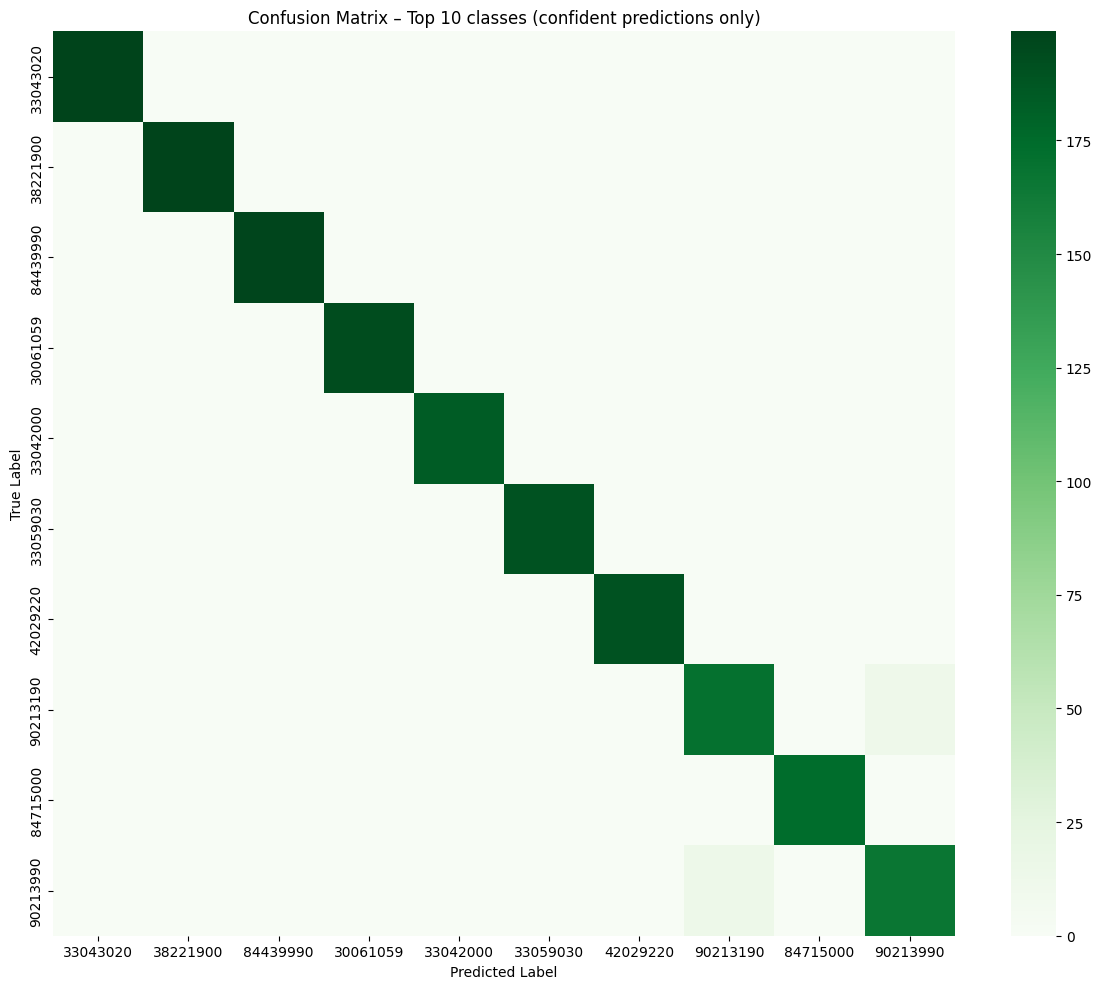

In [148]:
mask_conf = SVM_pred_labels_abstain != "UNSURE"
y_true = SVM_y_val[mask_conf]
y_pred = SVM_pred_labels_abstain[mask_conf]

print("Matriz de Confusión SVM")
print(" - Casos totales:", len(SVM_y_val))
print(" - Casos confiables:", len(y_true))
print(" - Coverage:", len(y_true) / len(SVM_y_val))

# Top-N clases por soporte en y_true
TOPN = int(SVM_n_classes * 0.2)
top_classes = y_true.value_counts().head(TOPN).index.tolist()

cm_top = confusion_matrix(y_true, y_pred, labels=top_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_top,
    annot=False,
    cmap="Greens",
    xticklabels=top_classes,
    yticklabels=top_classes,
    cbar=True
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix – Top {TOPN} classes (confident predictions only)")
plt.tight_layout()
plt.show()

In [151]:
# probar varios umbrales y elegir el que maximiza accuracy en predicciones confiables
taus = np.linspace(0.0, 2.0, 51)

best = None
for tau in taus:
    pred = SVM_pred_labels.copy()
    pred[SVM_margin < tau] = "UNSURE"
    mask = pred != "UNSURE"
    if mask.mean() < 0.5:
        continue  # evita quedarse con muy pocas predicciones
    acc_tau = accuracy_score(SVM_y_val[mask], pred[mask]) # Corregido: usar 'mask' en ambos argumentos
    cov = mask.mean()  # coverage: fracción de casos clasificados
    # objetivo: alta accuracy con cobertura razonable
    score = acc_tau * 0.7 + cov * 0.3
    cand = (tau, acc_tau, cov, score)
    if (best is None) or (cand[3] > best[3]):
        best = cand

print("[OK] Mejor TAU_MARGIN:", best[0])
print("[INFO] accuracy_confiable:", best[1], "| coverage:", best[2])

[OK] Mejor TAU_MARGIN: 0.2
[INFO] accuracy_confiable: 0.8742321370837375 | coverage: 0.9279


##### Backup

In [152]:
# Definir nombres según modo
suffix = "_test" if TEST_MODE else ""
SVM_DIR = Path(DIR_MODELS) / f"svm_multiclass{'_test' if TEST_MODE else '_final'}"
SVM_DIR.mkdir(parents=True, exist_ok=True)

model_path = SVM_DIR / f"svm_tfidf{suffix}.joblib"
classes_path = SVM_DIR / f"classes_in{suffix}.csv"
metrics_path = SVM_DIR / f"metrics_val{suffix}.json"

# Guardar modelo
joblib.dump(svm_clf, model_path)

# Guardar clases reales del clasificador (fuente de verdad)
pd.Series(svm_clf.classes_, name="classes_in").to_csv(classes_path, index=False)

# Guardar métricas (opcional pero recomendado)
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump({"val_accuracy": acc, "val_macro_f1": mf1}, f, ensure_ascii=False, indent=2)

print("[OK] SVM guardado en:", SVM_DIR)
print("[OK] Model:", model_path.name)
print("[OK] Classes:", classes_path.name)
print("[OK] Metrics:", metrics_path.name)

[OK] SVM guardado en: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/svm_multiclass_test
[OK] Model: svm_tfidf_test.joblib
[OK] Classes: classes_in_test.csv
[OK] Metrics: metrics_val_test.json


### Modelo BERT multiclase

#### Pámetros

In [218]:
# Base model
BERT_MODEL_NAME_MC = MODEL_NAME
MAX_LENGTH_MC = 64

# Entrenamiento
EPOCHS_MC = 2
LR_MC = 2e-5
WEIGHT_DECAY_MC = 0.01
WARMUP_RATIO_MC = 0.06

# Batch (ajustables)
BATCH_TRAIN_MC = 16
BATCH_EVAL_MC  = 32
GRAD_ACC_MC    = 2

# Workers
NUM_WORKERS_MC = 4

# Logging
LOGGING_STEPS_MC = 100

# Directorios
TMP_OUT_DIR = Path(DIR_MODELS) / ("tmp_multiclass_test" if TEST_MODE else "tmp_multiclass")
BERT_MC_DIR = Path(DIR_MODELS) / ("bert_multiclass_test" if TEST_MODE else "bert_multiclass_final")
BERT_MC_DIR.mkdir(parents=True, exist_ok=True)

if TEST_MODE:
    EPOCHS_MC = 1
    BATCH_TRAIN_MC = 32 # Aumentado para acelerar más en TEST_MODE
    BATCH_EVAL_MC  = 32
    GRAD_ACC_MC    = 2
    N_PER_CLASS_MC = 200 # Reducido para un dataset multiclase de prueba más pequeño

print("[INFO] BERT MULTICLASS CONFIG")
print(" - TEST_MODE:", TEST_MODE)
print(" - BERT_MODEL_NAME_MC:", BERT_MODEL_NAME_MC)
print(" - MAX_LENGTH_MC:", MAX_LENGTH_MC)
print(" - EPOCHS_MC:", EPOCHS_MC)
print(" - LR_MC:", LR_MC)
print(" - BATCH_TRAIN_MC:", BATCH_TRAIN_MC)
print(" - GRAD_ACC_MC:", GRAD_ACC_MC)
print(" - BATCH_EVAL_MC:", BATCH_EVAL_MC)
print(" - OUT_DIR:", BERT_MC_DIR)
print(" - TMP_OUT_DIR:", TMP_OUT_DIR)

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print("[INFO] device:", device)

[INFO] BERT MULTICLASS CONFIG
 - TEST_MODE: True
 - BERT_MODEL_NAME_MC: bert-base-multilingual-cased
 - MAX_LENGTH_MC: 64
 - EPOCHS_MC: 1
 - LR_MC: 2e-05
 - BATCH_TRAIN_MC: 32
 - GRAD_ACC_MC: 2
 - BATCH_EVAL_MC: 32
 - OUT_DIR: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/bert_multiclass_test
 - TMP_OUT_DIR: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/tmp_multiclass_test
[INFO] device: cuda


#### Dataset

In [219]:
# Checks de datos
assert "label_code" in df_train_mc.columns, "Falta columna label_code en df_train_mc"
assert COL_TEXT in df_train_mc.columns, f"Falta columna de texto {COL_TEXT}"

print("[INFO] tamaños:")
print(" - train:", len(df_train_mc))
print(" - val  :", len(df_val_mc))
print(" - test :", len(df_test_mc))

print("[INFO] ejemplos de texto (train):")
print(df_train_mc[COL_TEXT].astype(str).head(2).tolist())

print("[INFO] distribución de clases (train) top10:")
print(df_train_mc["label_code"].astype(str).value_counts().head(10))

# LabelEncoder (fit SOLO en train)
le = LabelEncoder()
le.fit(df_train_mc["label_code"].astype(str))
K = len(le.classes_)
print("[INFO] num_labels (K):", K)

# Si K es demasiado grande para su escenario test, puede limitarlo opcionalmente:
# (recomendación: no tocar aquí salvo que quiera reducir alcance)

[INFO] tamaños:
 - train: 70000
 - val  : 10000
 - test : 20000
[INFO] ejemplos de texto (train):
['SANDVIK-F; DE ACERO; PARA MAQUINA QUEBRANTADORA DE MINERALES SOLIDOS', 'URBAN; LUMINOUS; PREPARACION PARA EL MAQUILLAJE']
[INFO] distribución de clases (train) top10:
label_code
84314900    1400
33049100    1400
64041100    1400
85176210    1400
38221900    1400
84139100    1400
39269090    1400
85044000    1400
33059020    1400
64021900    1400
Name: count, dtype: int64
[INFO] num_labels (K): 50


#### Tokenizer

In [220]:
# Tokenizer + encoding
brt_tokenizer_mc = AutoTokenizer.from_pretrained(BERT_MODEL_NAME_MC, use_fast=True)

def encode_df_multiclass(df: pd.DataFrame, name: str):
    t0 = time.time()
    texts = df[COL_TEXT].fillna("").astype(str).map(preprocesar_texto).tolist()
    y = le.transform(df["label_code"].astype(str))
    empty = sum(len(x.strip()) == 0 for x in texts)
    print(f"[INFO] encode_df({name}) -> n={len(texts)} | empty_texts={empty} | time={time.time()-t0:.1f}s")
    return texts, y

BERT_train_texts, BERT_train_y = encode_df_multiclass(df_train_mc, "train")
BERT_val_texts,BERT_val_y = encode_df_multiclass(df_val_mc,   "val")
BERT_test_texts,BERT_test_y = encode_df_multiclass(df_test_mc,  "test")

[INFO] encode_df(train) -> n=70000 | empty_texts=0 | time=0.1s
[INFO] encode_df(val) -> n=10000 | empty_texts=0 | time=0.0s
[INFO] encode_df(test) -> n=20000 | empty_texts=0 | time=0.0s


#### Padding Dinámico

In [230]:

# Dataset + collator
class HSMultiDataset(Dataset):
    _name = None # Workaround for AttributeError with Trainer and custom torch.utils.data.Dataset

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if isinstance(idx, list):
            # Handle batched indexing by DataLoader
            texts = [self.texts[i] for i in idx]
            labels = [int(self.labels[i]) for i in idx]
            enc = self.tok(
                texts,
                truncation=True,
                max_length=self.max_length,
                padding=False
            )
            enc["labels"] = labels
            return enc

        # Handle single item indexing
        text = self.texts[idx]
        label = int(self.labels[idx])
        enc = self.tok(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False
        )
        enc["labels"] = label
        return enc

brt_train_mc_ds = HSMultiDataset(BERT_train_texts, BERT_train_y, brt_tokenizer_mc, MAX_LENGTH_MC)
brt_val_mc_ds = HSMultiDataset(BERT_val_texts, BERT_val_y, brt_tokenizer_mc, MAX_LENGTH_MC)
brt_test_mc_ds = HSMultiDataset(BERT_test_texts, BERT_test_y, brt_tokenizer_mc, MAX_LENGTH_MC)

data_collator_mc = DataCollatorWithPadding(
    tokenizer=brt_tokenizer_mc,
    pad_to_multiple_of=8
)

print("[INFO] datasets construidos:")
print(" - train_mc_ds:", len(brt_train_mc_ds))
print(" - val_mc_ds  :", len(brt_val_mc_ds))
print(" - test_mc_ds :", len(brt_test_mc_ds))

[INFO] datasets construidos:
 - train_mc_ds: 70000
 - val_mc_ds  : 10000
 - test_mc_ds : 20000


#### Métricas para BERT multiclase

In [231]:
# Métricas
def compute_metrics_mc(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }

print("[INFO] compute_metrics_mc listo (accuracy + macro_f1)")

[INFO] compute_metrics_mc listo (accuracy + macro_f1)


#### Modelo + TrainingArguments

In [234]:
# Modelo
BERT_model_mc = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL_NAME_MC,
    num_labels=K
)

brt_training_args_mc = TrainingArguments(
    output_dir=str(TMP_OUT_DIR),

    group_by_length=False, # Desactivado para evitar AttributeError con custom torch.utils.data.Dataset
    length_column_name="length",

    eval_strategy="no",
    save_strategy="no",

    logging_strategy="steps",
    logging_steps=LOGGING_STEPS_MC,

    per_device_train_batch_size=BATCH_TRAIN_MC,
    gradient_accumulation_steps=GRAD_ACC_MC,
    per_device_eval_batch_size=BATCH_EVAL_MC,

    num_train_epochs=EPOCHS_MC,
    learning_rate=LR_MC,
    weight_decay=WEIGHT_DECAY_MC,
    warmup_ratio=WARMUP_RATIO_MC,

    fp16=True,
    bf16=False,

    dataloader_num_workers=NUM_WORKERS_MC,
    remove_unused_columns=False,
    report_to="none",
    seed=SEED,
    disable_tqdm=False,
)

print("[INFO] TrainingArguments configurados")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] TrainingArguments configurados


#### Entrenamiento

In [235]:
# Trainer
BERT_trainer_mc = Trainer(
    model=BERT_model_mc,
    args=brt_training_args_mc,
    train_dataset=brt_train_mc_ds,
    eval_dataset=brt_val_mc_ds,
    tokenizer=brt_tokenizer_mc,
    data_collator=data_collator_mc,
    compute_metrics=compute_metrics_mc,
)

MODEL_MARKER = BERT_MC_DIR / "config.json"

if MODEL_MARKER.exists() and not TEST_MODE:
    print("[INFO] Modelo multiclase ya existe, cargando desde:", BERT_MC_DIR)
    brt_tokenizer_mc = AutoTokenizer.from_pretrained(str(BERT_MC_DIR), use_fast=True)
    BERT_model_mc = AutoModelForSequenceClassification.from_pretrained(str(BERT_MC_DIR))
    BERT_trainer_mc.model = BERT_model_mc
else:
    print("[INFO] Iniciando entrenamiento BERT multiclase...")
    print(" - epochs:", EPOCHS_MC)
    print(" - batch_train:", BATCH_TRAIN_MC)
    print(" - grad_acc:", GRAD_ACC_MC)
    print(" - batch_eval:", BATCH_EVAL_MC)
    print(" - lr:", LR_MC)
    print(" - num_labels:", K)

    t0 = time.time()
    train_out_mc = BERT_trainer_mc.train()
    dt = time.time() - t0

    print("[OK] Entrenamiento completado")
    print("[INFO] tiempo (s):", round(dt, 2))
    print("[INFO] métricas train:", train_out_mc.metrics)

    # Guardar artefactos
    BERT_trainer_mc.save_model(str(BERT_MC_DIR))
    brt_tokenizer_mc.save_pretrained(str(BERT_MC_DIR))

    with open(BERT_MC_DIR / ("train_output_test.json" if TEST_MODE else "train_output.json"), "w", encoding="utf-8") as f:
        json.dump(train_out_mc.metrics, f, ensure_ascii=False, indent=2)

    with open(BERT_MC_DIR / ("label_encoder_classes_test.json" if TEST_MODE else "label_encoder_classes.json"), "w", encoding="utf-8") as f:
        json.dump(le.classes_.tolist(), f, ensure_ascii=False, indent=2)

    print("[OK] Artefactos guardados en:", BERT_MC_DIR)

/tmp/ipython-input-1647132407.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  BERT_trainer_mc = Trainer(


[INFO] Iniciando entrenamiento BERT multiclase...
 - epochs: 1
 - batch_train: 32
 - grad_acc: 2
 - batch_eval: 32
 - lr: 2e-05
 - num_labels: 50


Step,Training Loss
100,3.684900
200,2.584800
300,1.823000
400,1.442600
500,1.240700
600,1.095100
700,1.058300
800,0.984700
900,0.939600
1000,0.915900


[OK] Entrenamiento completado
[INFO] tiempo (s): 214.68
[INFO] métricas train: {'train_runtime': 214.2175, 'train_samples_per_second': 326.771, 'train_steps_per_second': 5.107, 'total_flos': 1988529100151808.0, 'train_loss': 1.5187336016834545, 'epoch': 1.0}
[OK] Artefactos guardados en: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/bert_multiclass_test


#### Evaluación

In [245]:
# Evaluación final
print("[INFO] Evaluando en VAL...")
brt_val_pred = BERT_trainer_mc.predict(brt_val_mc_ds)
brt_val_metrics = compute_metrics_mc((brt_val_pred.predictions, brt_val_pred.label_ids))
print("[BERT-MC] VAL metrics:", brt_val_metrics)





[INFO] Evaluando en VAL...


[BERT-MC] VAL metrics: {'accuracy': 0.7573, 'macro_f1': 0.7511791954981497}


In [246]:
print("[INFO] Evaluando en TEST...")
brt_test_pred = BERT_trainer_mc.predict(brt_test_mc_ds)
brt_test_metrics = compute_metrics_mc((brt_test_pred.predictions, brt_test_pred.label_ids))
print("[BERT-MC] TEST metrics:", brt_test_metrics)

[INFO] Evaluando en TEST...


[BERT-MC] TEST metrics: {'accuracy': 0.7603, 'macro_f1': 0.7550597870724238}


In [247]:
# Reporte detallado (opcional, puede ser largo si K grande)
brt_preds_test = np.argmax(brt_test_pred.predictions, axis=1)
brt_y_true_test = brt_test_pred.label_ids

# Convertir a etiquetas HS para reporte legible
brt_y_true_hs = le.inverse_transform(brt_y_true_test)
brt_y_pred_hs = le.inverse_transform(brt_preds_test)

print("[INFO] Classification report (TEST):")
print(classification_report(brt_y_true_hs, brt_y_pred_hs, digits=4))

[INFO] Classification report (TEST):
              precision    recall  f1-score   support

    30061059     0.9578    0.9650    0.9614       400
    33030010     0.6036    0.8300    0.6989       400
    33030020     0.7063    0.4750    0.5680       400
    33041000     0.9010    0.8650    0.8827       400
    33042000     0.9536    0.8225    0.8832       400
    33043020     0.9872    0.9625    0.9747       400
    33049100     0.5687    0.8900    0.6940       400
    33049980     0.7554    0.7875    0.7711       400
    33049990     0.6038    0.3200    0.4183       400
    33051010     0.9501    0.8100    0.8745       400
    33059020     0.5416    0.7975    0.6451       400
    33059030     0.8352    0.9375    0.8834       400
    33059090     0.6745    0.3575    0.4673       400
    38221900     0.9330    0.9750    0.9535       400
    39269090     0.8234    0.7925    0.8076       400
    40169390     0.9453    0.9075    0.9260       400
    42029220     0.9695    0.9550    0.9622 

##### Matriz de Confusión

[INFO] Matriz de Confusión para BERT Multiclase (primeras 10x10 clases):


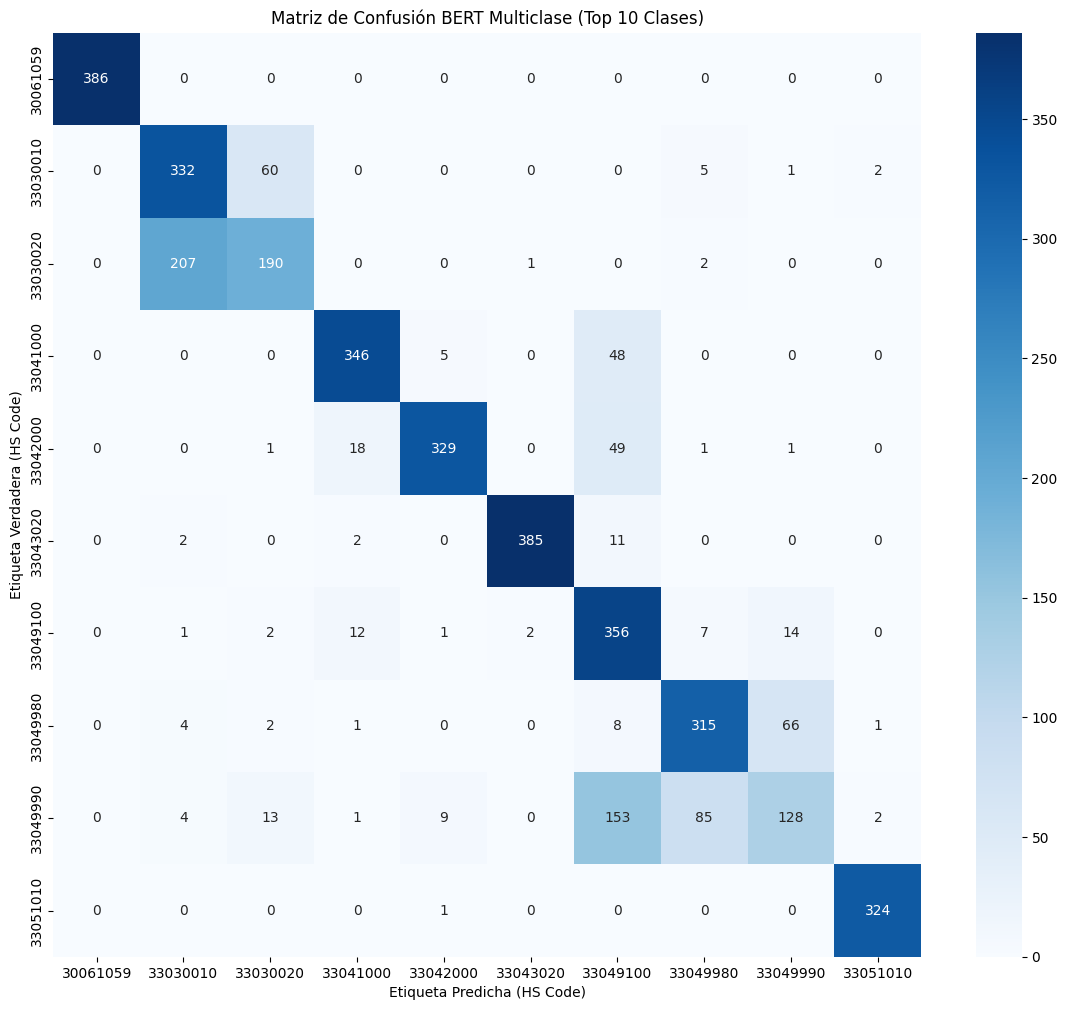

In [251]:
# Calcular la matriz de confusión
# Se usa 'le.classes_' para asegurar que las etiquetas estén en el orden correcto.
brt_cm_bert_mc = confusion_matrix(brt_y_true_hs, brt_y_pred_hs, labels=le.classes_)

print("[INFO] Matriz de Confusión para BERT Multiclase (primeras 10x10 clases):")
# Para un alto número de clases, mostrar solo una parte o sin anotaciones para no saturar
plt.figure(figsize=(14, 12))
sns.heatmap(brt_cm_bert_mc[:10, :10], annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_[:10], yticklabels=le.classes_[:10])
plt.xlabel('Etiqueta Predicha (HS Code)')
plt.ylabel('Etiqueta Verdadera (HS Code)')
plt.title('Matriz de Confusión BERT Multiclase (Top 10 Clases)')
plt.show()

##### Backup

In [252]:

# Guardar métricas finales
brt_metrics_path = BERT_MC_DIR / ("eval_metrics_test.json" if TEST_MODE else "eval_metrics.json")
payload = {
    "val": brt_val_metrics,
    "test": brt_test_metrics,
    "K": int(K),
    "model_name": BERT_MODEL_NAME_MC,
    "max_length": int(MAX_LENGTH_MC),
    "test_mode": bool(TEST_MODE),
}

with open(brt_metrics_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

print("[OK] Métricas guardadas en:", metrics_path)

[OK] Métricas guardadas en: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/bert_multiclass_test/eval_metrics_test.json


### Inferencia Arquitectura Completa

In [253]:

# Cargar τ
INOUT_DIR = Path(DIR_MODELS) / "bert_inout_ckpt_final"
with open(INOUT_DIR / "thresholds.json", "r", encoding="utf-8") as f:
    th = json.load(f)
TAU_IN = float(th["tau_in"])

def predict_inout_proba(text: str) -> float:
    text = preprocesar_texto(text)
    enc = tokenizer(text, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
    proba_in = torch.softmax(logits, dim=-1).cpu().numpy()[0, 1]
    return float(proba_in)

def route_predict(text: str, head: str = "svm"):
    proba_in = predict_inout_proba(text)
    is_in = (proba_in >= TAU_IN)

    if not is_in:
        return {
            "route": "OUT",
            "hs_code": None,
            "proba_in": proba_in
        }

    # IN: aplicar head
    if head == "svm":
        hs = svm_clf.predict([preprocesar_texto(text)])[0]
        return {"route": "IN", "hs_code": hs, "proba_in": proba_in, "head": "svm"}

    if head == "bert":
        t = preprocesar_texto(text)
        enc = brt_tokenizer_mc(t, truncation=True, max_length=MAX_LENGTH_MC, return_tensors="pt")
        enc = {k: v.to("cuda") for k, v in enc.items()}  # en Colab
        with torch.no_grad():
            logits = BERT_model_mc(**enc).logits
        pred = int(torch.argmax(logits, dim=-1).cpu().numpy()[0])
        hs = le.classes_[pred]
        return {"route": "IN", "hs_code": hs, "proba_in": proba_in, "head": "bert"}

    raise ValueError("head debe ser 'svm' o 'bert'")

Test

In [254]:
# dataset fuente
df_src = df_test_mc if "df_test_mc" in globals() else df_val_mc

assert COL_TEXT in df_src.columns, f"Falta COL_TEXT={COL_TEXT} en df_src"
assert "label_code" in df_src.columns, "Falta columna 'label_code' en df_src (ajuste el nombre si es distinto)"

# Seleccionar fila aleatoria
row = df_src.sample(1, random_state=None).iloc[0]
sample_text = str(row[COL_TEXT])
true_label = str(row["label_code"])




[INFO] Ejemplo aleatorio desde dataset
- Texto: CARRIER; ELECTRONICO; DE ACERO,ARTICULO DE GRIFERIA PARA TUBERIAS
- True label (dataset): 84818090


In [260]:
# Helper para extraer etiqueta predicha
def _extract_pred_label(pred):
    """
    route_predict puede devolver:
    - string (label)
    - dict con clave 'pred' o 'label' o similar
    - tuple/list donde el primer elemento sea label
    Ajuste si su route_predict retorna otra estructura.
    """
    if isinstance(pred, str):
        return pred
    if isinstance(pred, dict):
        for k in ["pred", "label", "hs_code", "prediction"]:
            if k in pred:
                return str(pred[k])
        # fallback: string del dict
        return str(pred)
    if isinstance(pred, (tuple, list)) and len(pred) > 0:
        return str(pred[0])
    return str(pred)

def clasificar_texto(texto):

  print("[INFO] Evaluación de Clasificación Código Arancelario")
  print("- Texto:", texto)
  print("- True label (dataset):", true_label)

  # Ejecutar predicciones
  print("\n[INFO] Clasificador SVM:")
  pred_svm_raw = route_predict(texto, head="svm")
  pred_svm = _extract_pred_label(pred_svm_raw)
  print(" - Pred:", pred_svm)
  print(" - OK? :", pred_svm == true_label)

  print("\n[INFO] Clasificador BERT:")
  pred_bert_raw = route_predict(texto, head="bert")
  pred_bert = _extract_pred_label(pred_bert_raw)
  print(" - Pred:", pred_bert)
  print(" - OK? :", pred_bert == true_label)


In [261]:
sample_text = "CARRIER; ELECTRONICO; DE ACERO,ARTICULO DE GRIFERIA PARA TUBERIAS"
clasificar_texto(sample_text)

[INFO] Evaluación de Clasificación Código Arancelario
- Texto: CARRIER; ELECTRONICO; DE ACERO,ARTICULO DE GRIFERIA PARA TUBERIAS
- True label (dataset): 84818090

[INFO] Clasificador SVM:
 - Pred: 84818090
 - OK? : True

[INFO] Clasificador BERT:
 - Pred: 84818090
 - OK? : True
